# Preliminaries

The raw code may be hidden to draw attention to the results. Please use the button below if desired.

In [40]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

## Importing Libraries

We import the necessary packages and libraries for the analysis.

In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
from pytrends.request import TrendReq
import pytrends
from sklearn.metrics import mean_squared_error 
import os
from tqdm.notebook import tqdm
from fbprophet import Prophet
sns.set(font='DejaVu Sans')

In [2]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [3]:
%matplotlib inline

In [4]:
path = 'C:\\Users\\Dominique\\Documents\\Work\\ADB\\Nowcasting\\Data'
os.chdir(path)

## Importing Data

Here, we import the consolidated data.

In [5]:
df = pd.read_stata('monthly_nc.dta')

df['wdate'] = pd.to_datetime(df.wdate)
df.set_index('wdate', inplace=True)
df.drop(columns=['mdate','month','year'], inplace=True)

In [22]:
# create sub-region variable
asean4 = ['IDN', 'PHL', 'SGP', 'THA']
cmlv = ['MMR', 'VNM']
east = ['CHN', 'JPN', 'KOR', 'TWN']
pac = ['AUS', 'NZL']

df['regions'] = 'ASEAN-4'
df.loc[df['country'].isin(cmlv), 'regions'] = 'CMLV'
df.loc[df['country'].isin(east), 'regions'] = 'East Asia'
df.loc[df['country'].isin(pac), 'regions'] = 'Pacific and Oceania'

In [25]:
iso = pd.read_excel(path + '\iso_codes.xlsx', header=0)
iso_dict = dict(zip(iso['Alpha-2 code'], iso['Alpha-3 code']))
df['country'].replace(iso_dict, inplace=True)

In [26]:
df.head()

country   pmi  entertainment  restaurants  hotels  transportation  \
wdate                                                                          
2018-01-07     AUS  55.4             90         80.5   87.25            61.0   
2018-01-14     AUS  55.4             82         77.5   87.25            65.5   
2018-01-21     AUS  55.4             86         78.0   81.00            59.5   
2018-01-28     AUS  55.4             77         71.5   82.00            56.0   
2018-02-04     AUS  55.6             74         73.5   72.00            58.5   

            flights    tourism  industry  stbond  pe_ratio  \
wdate                                                        
2018-01-07       65  81.666667      68.5     NaN       NaN   
2018-01-14       68  82.333333      73.0     NaN       NaN   
2018-01-21       62  73.666667      56.5     NaN       NaN   
2018-01-28       73  74.666667      63.5     NaN       NaN   
2018-02-04       64  81.000000      74.0    1.94       NaN   

                        regions  
wdate                            
2018-01-07  Pacific and Oceania  
2018-01-14  Pacific and Oceania  
2018-01-21  Pacific and Oceania  
2018-01-28  Pacific and Oceania  
2018-02-04  Pacific and Oceania

## Defining Functions

Here, we define various helper functions to make the analysis less verbose.

In [27]:
# dictionary of variables and labels
var_dict = {
    'pmi': 'Purchasing Managers Index',
    'entertainment': 'Entertainment - Search Index',
    'hotels': 'Hotels - Search Index',
    'transportation': 'Transportation - Search Index',
    'flights': 'Flights - Search Index',
    'restaurants': 'Restaurants - Search Index',
    'tourism': 'Tourism - Search Index',
    'industry': 'Industry - Search Index',
    'stbond': 'Short-Term Bond Yield',
    'pe_ratio': 'P/E Ratio - Stock Index'
}

In [28]:
# set default size and style for all plots 
fig_dims = (6, 3)
dpi = 200
sns.set(style="white")

In [29]:
# Plotting trends helper function
def plot_vars(region, reg_str): 
    """
    Helper function for plotting each variable, iteratively.
    """
    for var, label in var_dict.items():
        data = df[df.country.isin(region)]
        if data[var].isna().sum() != len(data):
            fig, ax = plt.subplots(figsize=fig_dims, dpi=dpi)
            palette = dict(zip(data.country.unique(), sns.color_palette('tab10')))

            sns.lineplot(data=data,
                         y=var,
                         x=data.index,
                         hue='country',
                         legend='brief',
                         palette=palette)
            plt.xticks(rotation=45)
            plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
            plt.ylabel(label)
            plt.xlabel('')
            ax.set_title(reg_str + ': ' + label + ', 2017-2020')
        else:
            break

In [30]:
# Define a stationarity test

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

def st_check(timeseries, country, variable, diff=False):  
    """
    Helper function for checking stationarity 
    """
    if diff==True:
        timeseries = df[df.country==country]
        timeseries = timeseries[variable].diff()
    else:
        timeseries = df[df.country==country]
        timeseries = timeseries[variable]
        
    rolmean = pd.Series(timeseries).rolling(window=12).mean() ## as month is year divide by 12
    rolstd = pd.Series(timeseries).rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std  = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation: {}'.format(country))
    plt.xticks(rotation=45)
    plt.show()
    
    #Perform Dickey-Fuller test
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    #Perform KPSS Test:
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries.dropna(), regression='ct')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [31]:
def plot_corr(df, country, tr_start, tr_end, te_start, te_end, diff=False):
    """
    Correlogram plotter
    """
    df = df[df.country == country]
    tra = df['pmi'][tr_start:tr_end].dropna()
    tes = df['pmi'][te_start:te_end].dropna()
    fig,ax = plt.subplots(1,2,figsize=(10,5))
    if diff==True:
        fig = sm.graphics.tsa.plot_acf(tra.diff().dropna(), lags=20, ax=ax[0])
        fig = sm.graphics.tsa.plot_pacf(tra.diff().dropna(), lags=20, ax=ax[1])
    else:
        fig = sm.graphics.tsa.plot_acf(tra.dropna(), lags=20, ax=ax[0])
        fig = sm.graphics.tsa.plot_pacf(tra.dropna(), lags=20, ax=ax[1])
    plt.suptitle('ACF and PACF: {}'.format(country))
    plt.show()

In [32]:
def fit_arima(country, tr_start, tr_end, te_start, te_end, order, df=df):
    buf = df[df.country == country]

    tra = buf['pmi'][tr_start:tr_end].dropna()
    tes = buf['pmi'][te_start:te_end].dropna()

    arima = sm.tsa.statespace.SARIMAX(tra,order=order,
                                    enforce_stationarity=False, 
                                    enforce_invertibility=False).fit()
    print(arima.summary())

    res = arima.resid
    fig,ax = plt.subplots(2,1,figsize=(15,8))
    fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
    fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
    plt.title('Correlograms for country: {}'.format(country))
    plt.show()

    pred = arima.predict(80,90)[1:]
    print('ARIMA model MSE for 10-step ahead forecast:{}'.format(mean_squared_error(tra[-10:],pred)))

    pd.DataFrame({'test':tra[-10:].values,'pred':pred.values}).plot();
    plt.title('10-Step Ahead ARIMA Forecast for {}'.format(country))
    plt.show()

In [95]:
def fit_arimax(country,
               exog_vars,
               tr_start,
               tr_end,
               te_start,
               te_end,
               order,
               n,
               df=df):
    buf = df[df.country == country]

    tra = buf['pmi'][tr_start:tr_end].dropna()
    tes = buf['pmi'][te_start:te_end].dropna()
    
    exog_tra = buf[exog_vars][tr_start:tr_end].dropna()
    exog_tes = buf[exog_vars][te_start:te_end].dropna()
    
    arimax = sm.tsa.statespace.SARIMAX(
        tra,
        order=order,
        exog=exog_tra,
        enforce_stationarity=False,
        enforce_invertibility=False
    ).fit()
    print(arimax.summary())

    res = arimax.resid
    fig, ax = plt.subplots(2, 1, figsize=(15, 8))
    fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
    fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
    plt.title('Correlograms for country: {}'.format(country))
    plt.show()

#     pred = arimax.predict(80, 90, exog=buf[exog_vars][-30:])[1:]
    pred = arimax.predict(80, 90, exog=buf[exog_vars][n:])[1:]
    print('ARIMAX model MSE for 10-step ahead forecast:{}'.format(
        mean_squared_error(tra[-10:], pred)))

    pd.DataFrame({
        'test': tra[-10:].values,
        'pred': pred.values
    }).plot()
    plt.title('10-Step Ahead ARIMAX Forecast for {}'.format(country))
    plt.show()

## Summary Statistics

Basic summary statistics

In [15]:
df.describe()

pmi  entertainment  restaurants       hotels  transportation  \
count  1205.000000    1205.000000  1205.000000  1205.000000      1205.00000   
mean     49.985394      70.359336    63.198755    52.318257        46.10083   
std       4.768164      12.635952    16.639103    17.222834        16.19634   
min      27.400000      25.000000    10.500000     2.750000         1.00000   
25%      48.700000      62.000000    54.500000    44.500000        34.50000   
50%      51.100000      70.000000    67.000000    56.250000        47.00000   
75%      52.600000      79.000000    74.500000    64.500000        58.00000   
max      59.700000     100.000000   100.000000    94.000000        94.50000   

           flights      tourism     industry      stbond    pe_ratio  
count  1205.000000  1205.000000  1205.000000  320.000000  269.000000  
mean     45.553527    64.973721    55.317427    1.973544   17.891338  
std      21.474040    15.956514    18.407336    1.976889    5.377278  
min       0.000000    17.000000     0.000000   -0.279000    9.720000  
25%      29.000000    59.000000    43.500000    0.481200   13.560000  
50%      46.000000    68.666667    57.000000    1.670000   16.620000  
75%      62.000000    76.000000    69.000000    2.678500   23.230000  
max     100.000000    94.333333    94.500000    7.127024   28.900000

Observations per country

In [16]:
df.groupby('country').count()

pmi  entertainment  restaurants  hotels  transportation  flights  \
country                                                                     
AUS      108            108          108     108             108      108   
CHN      102            102          102     102             102      102   
IDN      111            111          111     111             111      111   
IND       93             93           93      93              93       93   
JPN       97             97           97      97              97       97   
KOR       81             81           81      81              81       81   
MMR       92             92           92      92              92       92   
MYS       92             92           92      92              92       92   
NZL       85             85           85      85              85       85   
PHL       74             74           74      74              74       74   
SGP       75             75           75      75              75       75   
THA       62             62           62      62              62       62   
TWN       94             94           94      94              94       94   
VNM       39             39           39      39              39       39   

         tourism  industry  stbond  pe_ratio  regions  
country                                                
AUS          108       108      59         0      108  
CHN          102       102       0        72      102  
IDN          111       111      44         0      111  
IND           93        93       0        89       93  
JPN           97        97      46         0       97  
KOR           81        81      32        62       81  
MMR           92        92       0         0       92  
MYS           92        92      43         0       92  
NZL           85        85      33         0       85  
PHL           74        74       0         0       74  
SGP           75        75       0         0       75  
THA           62        62      27        46       62  
TWN           94        94      36         0       94  
VNM           39        39       0         0       39

Mean values per country

In [17]:
df.groupby('country').mean()

pmi  entertainment  restaurants     hotels  transportation  \
country                                                                     
AUS      51.670370      72.777778    70.935185  63.229167       56.375000   
CHN      49.906863      57.901961    53.637255  41.607843       36.397059   
IDN      50.783784      73.261261    55.635135  55.786036       45.153153   
IND      50.784946      77.494624    57.811828  58.322581       61.279570   
JPN      49.272165      62.041237    65.025773  53.667526       42.438144   
KOR      49.506173      68.876543    68.209877  54.216049       28.481481   
MMR      49.756522      78.706522    59.771739  31.959239       33.467391   
MYS      48.278261      74.304348    65.211957  58.173913       51.304348   
NZL      49.492941      70.988235    63.847059  50.129412       49.000000   
PHL      49.700000      63.945946    70.655405  56.668919       46.418919   
SGP      50.073333      64.773333    72.540000  52.370000       52.413333   
THA      48.622581      84.322581    47.395161  49.495968       44.500000   
TWN      51.590426      64.212766    68.755319  54.382979       53.101064   
VNM      48.425641      79.897436    67.743590  48.769231       39.371795   

           flights    tourism   industry    stbond   pe_ratio  
country                                                        
AUS      62.277778  70.716049  66.759259  1.285763        NaN  
CHN      29.235294  55.617647  31.813725       NaN  14.584167  
IDN      59.018018  63.036036  73.225225  6.193059        NaN  
IND      33.989247  75.688172  71.586022       NaN  24.590225  
JPN      56.958763  57.742268  75.644330 -0.172913        NaN  
KOR      50.061728  74.119342  57.574074  1.565500  12.795161  
MMR      29.902174  55.431159  27.836957       NaN        NaN  
MYS      52.478261  71.452899  57.494565  3.130930        NaN  
NZL      51.141176  57.874510  49.288235  1.537879        NaN  
PHL      32.567568  71.018018  53.540541       NaN        NaN  
SGP      33.440000  64.524444  50.293333       NaN        NaN  
THA      45.145161  70.311828  52.250000  1.463123  16.975652  
TWN      50.787234  64.177305  50.861702  0.448697        NaN  
VNM      37.820513  58.025641  41.576923       NaN        NaN

# Visualization

### Distributions

Here we visually examine the variables with a Seaborn pairplot showing the distributions of each variable, by sub-region. We see that CMLV tends to veer towards the lower end of the distribution, whereas the opposite is true for Pacific and Oceania and for East Asia.

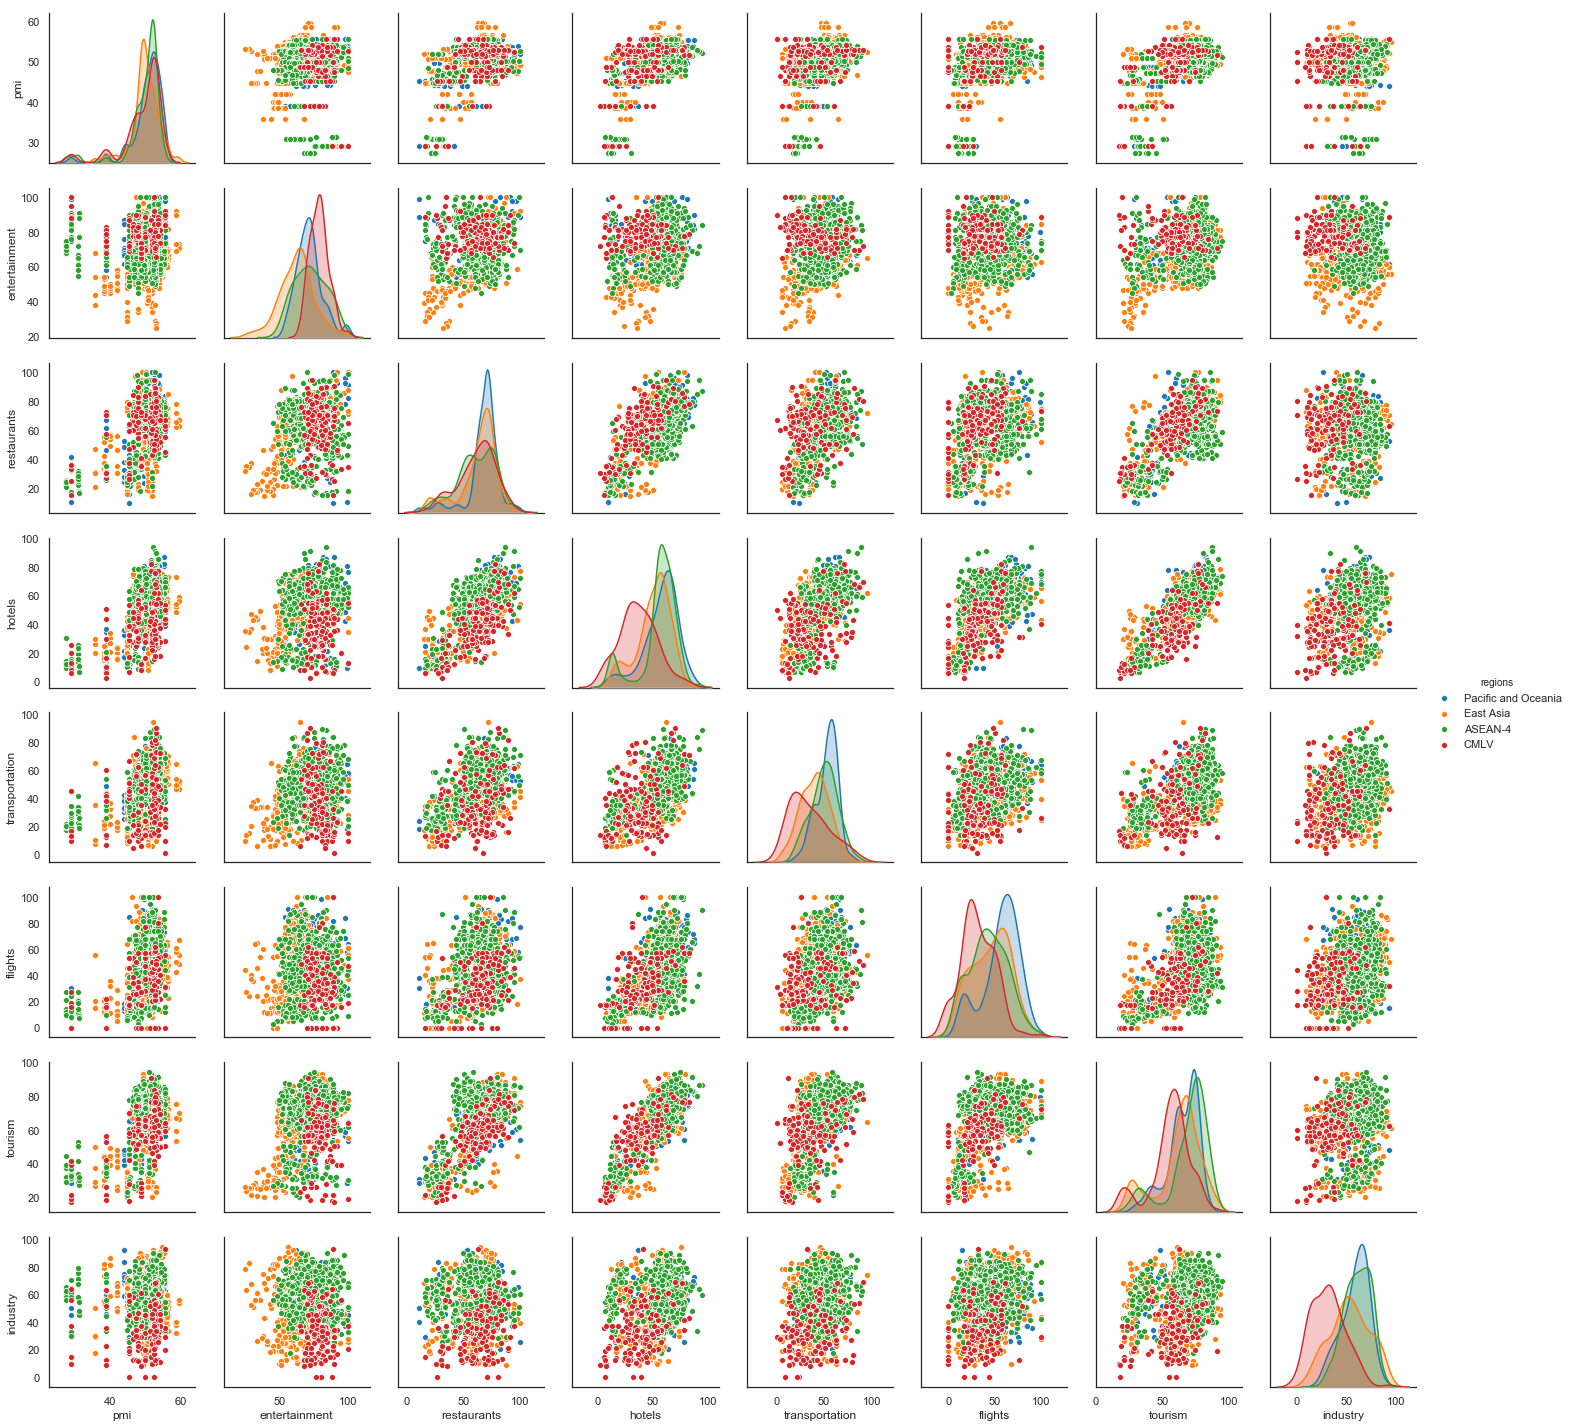

In [34]:
import warnings
warnings.filterwarnings("ignore")
sns.pairplot(data=df, vars=['pmi', 'entertainment', 'restaurants', 'hotels',
       'transportation', 'flights', 'tourism', 'industry'], hue='regions', palette='tab10');

### Basic Trends
This section illustrates the basic behavior of the various variables we have in the dataset, separated by sub-region and country. 

In [35]:
globals()['region'] = [asean4, cmlv, east, pac]
regions = ['ASEAN-4', 'CMLV', 'East Asia', 'Pacific and Oceania']

#### ASEAN-4 Countries

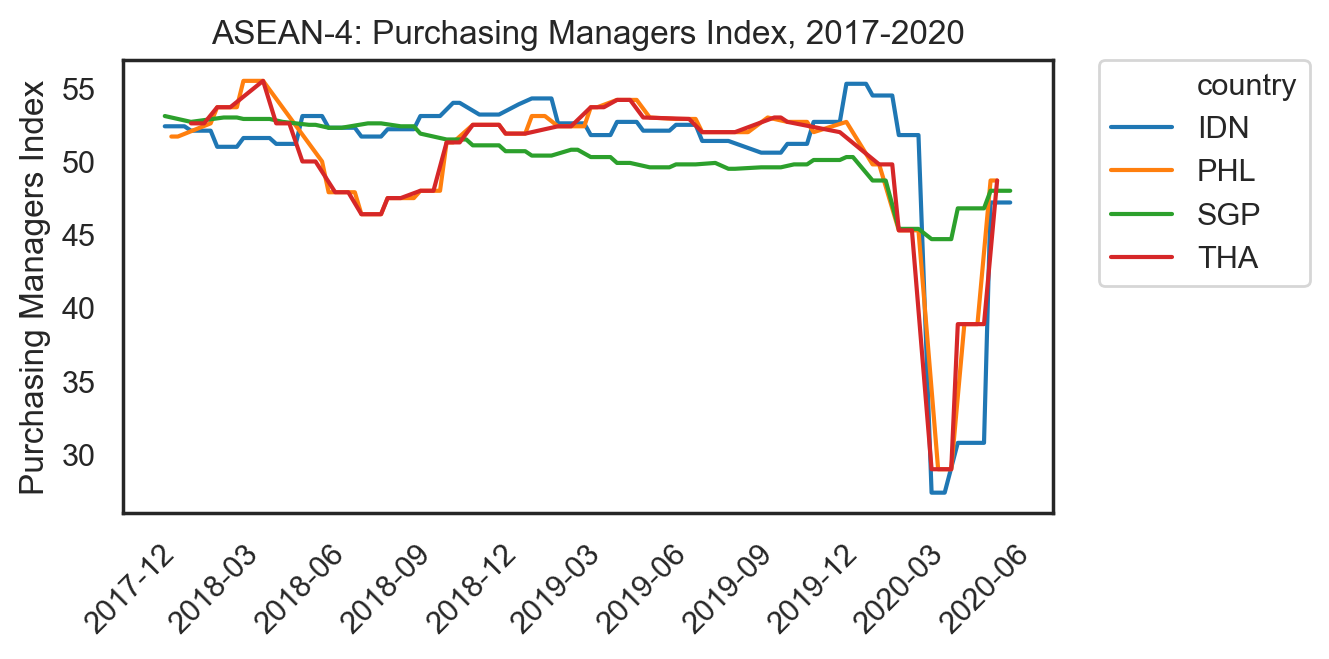

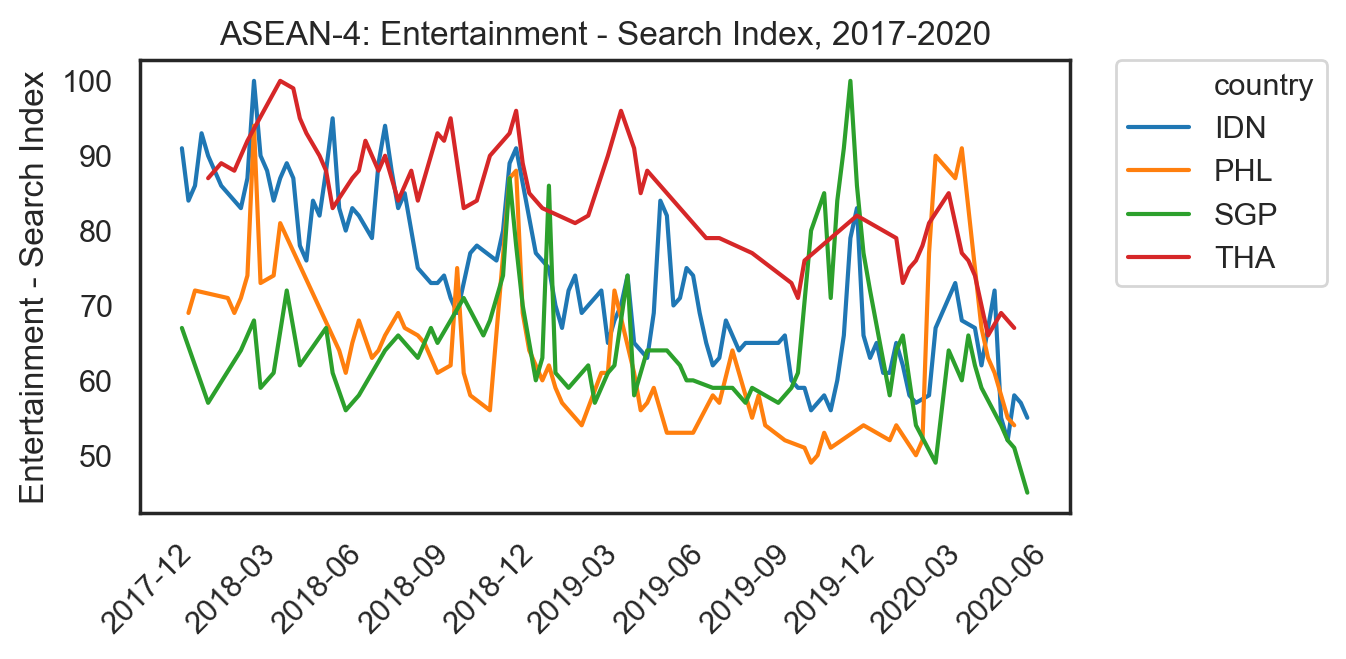

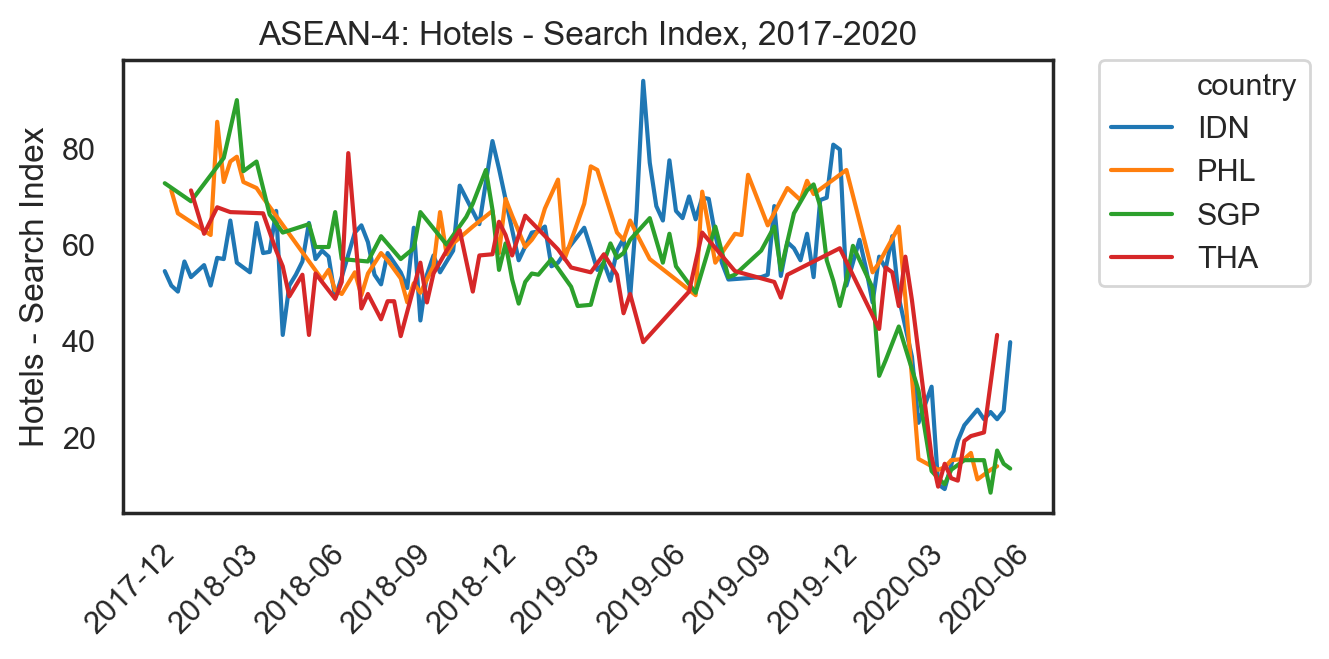

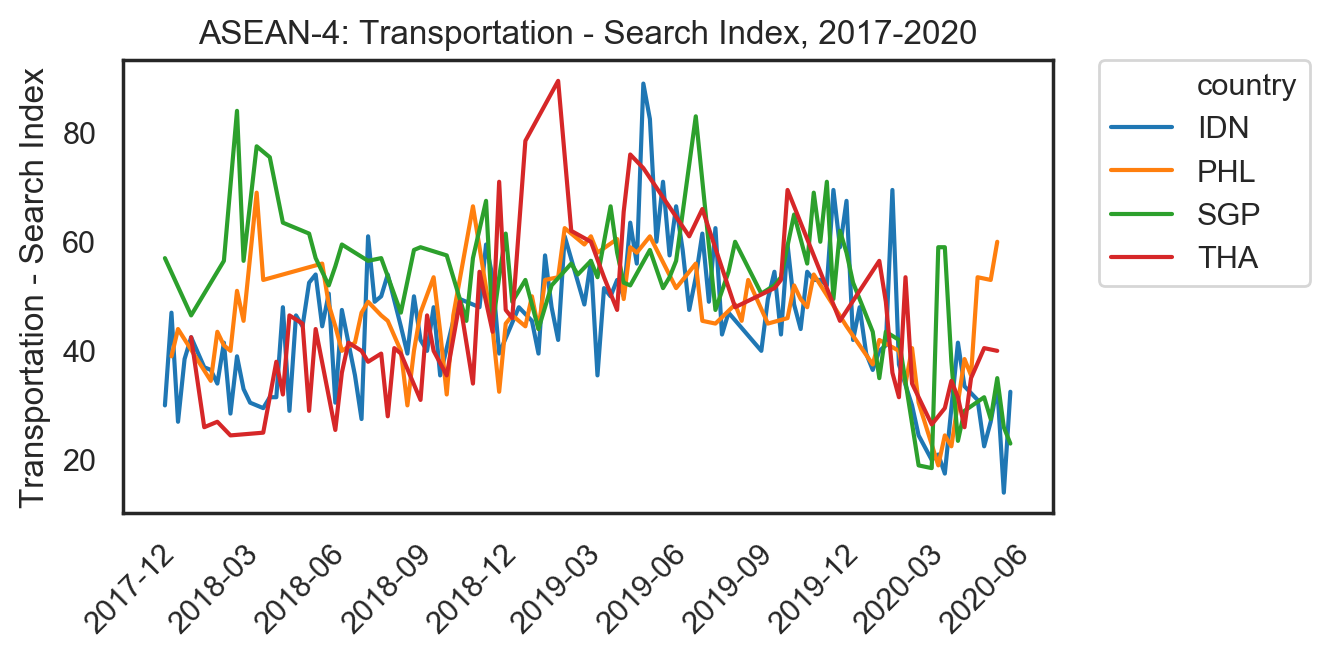

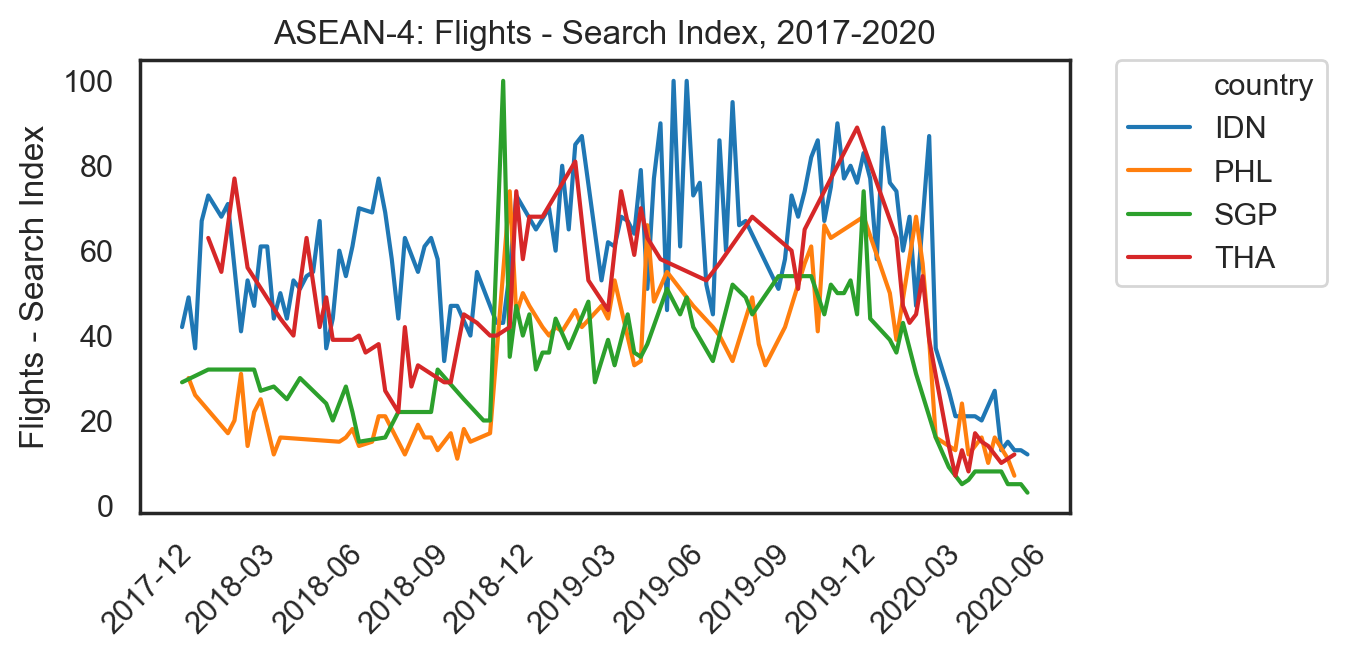

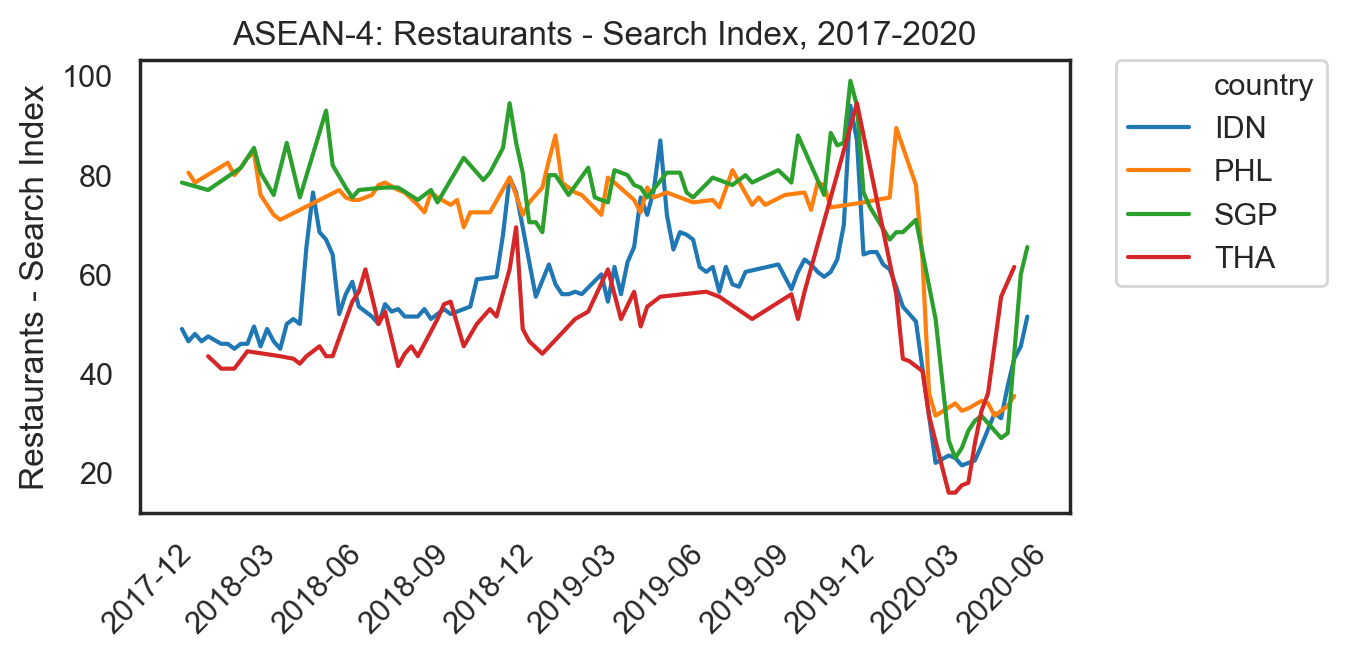

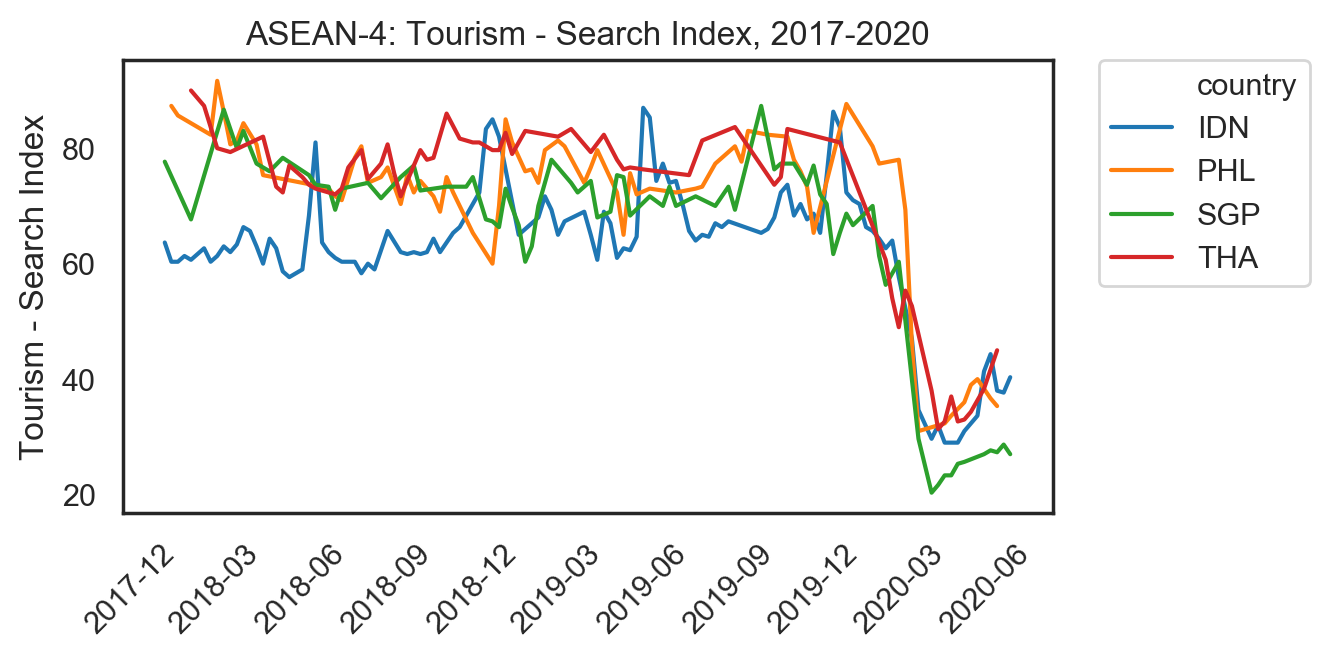

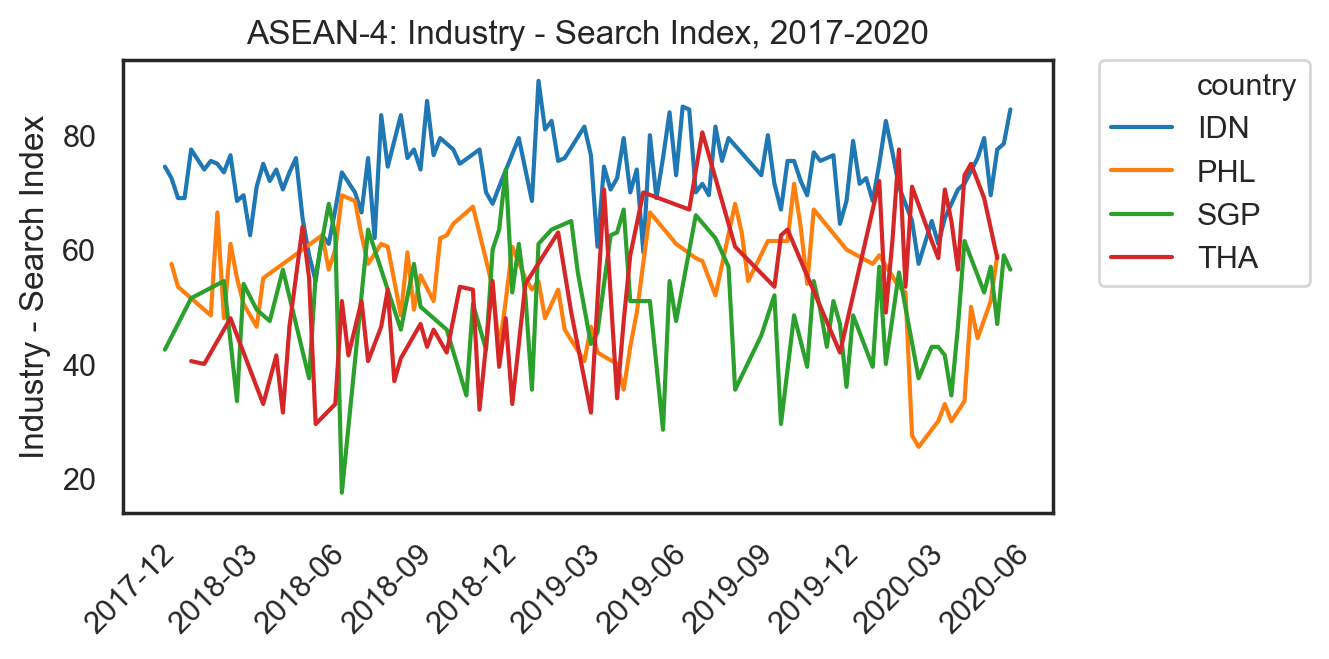

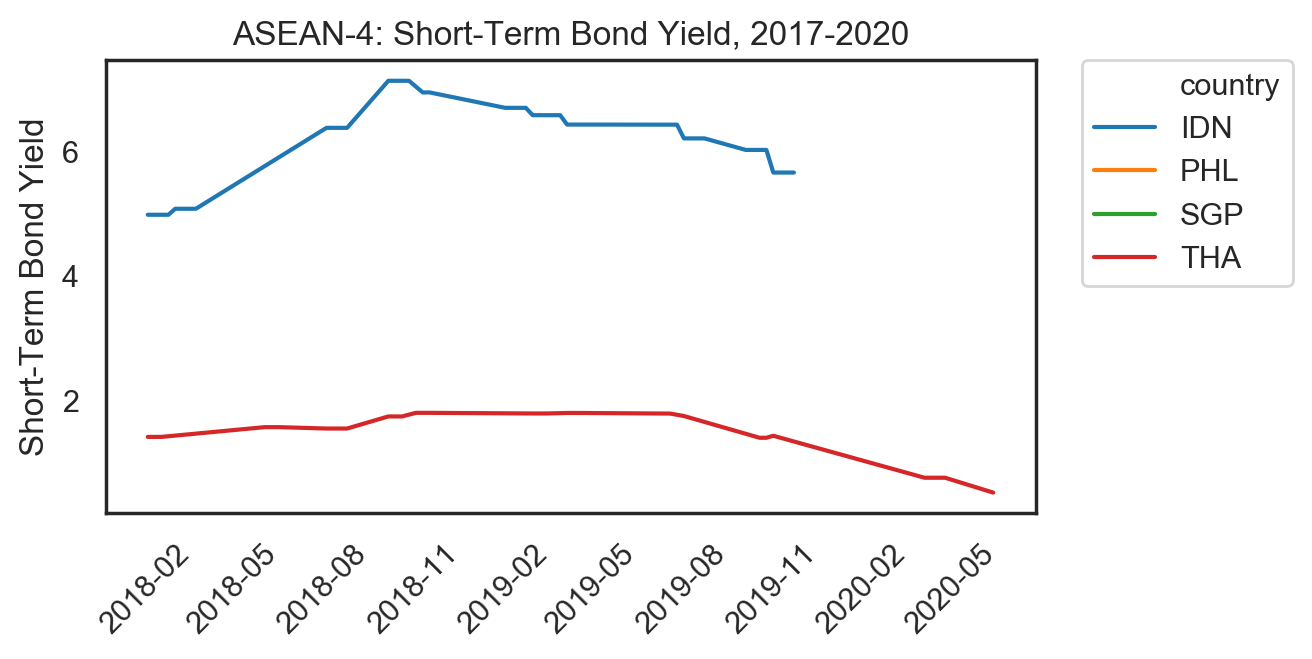

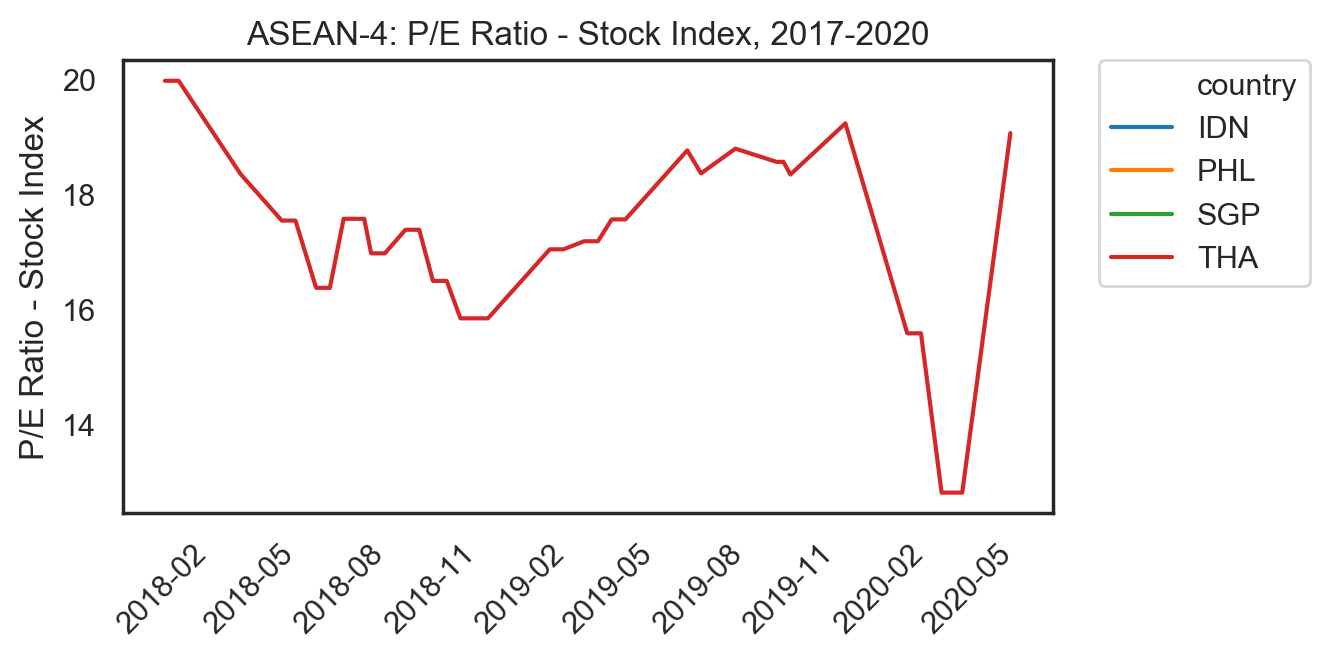

In [36]:
# Hotels, transportation*, flights*, restaurants, and tourism seem to have more reasonable trends
region = asean4
reg_str = "ASEAN-4"
plot_vars(region, reg_str)

#### CMLV

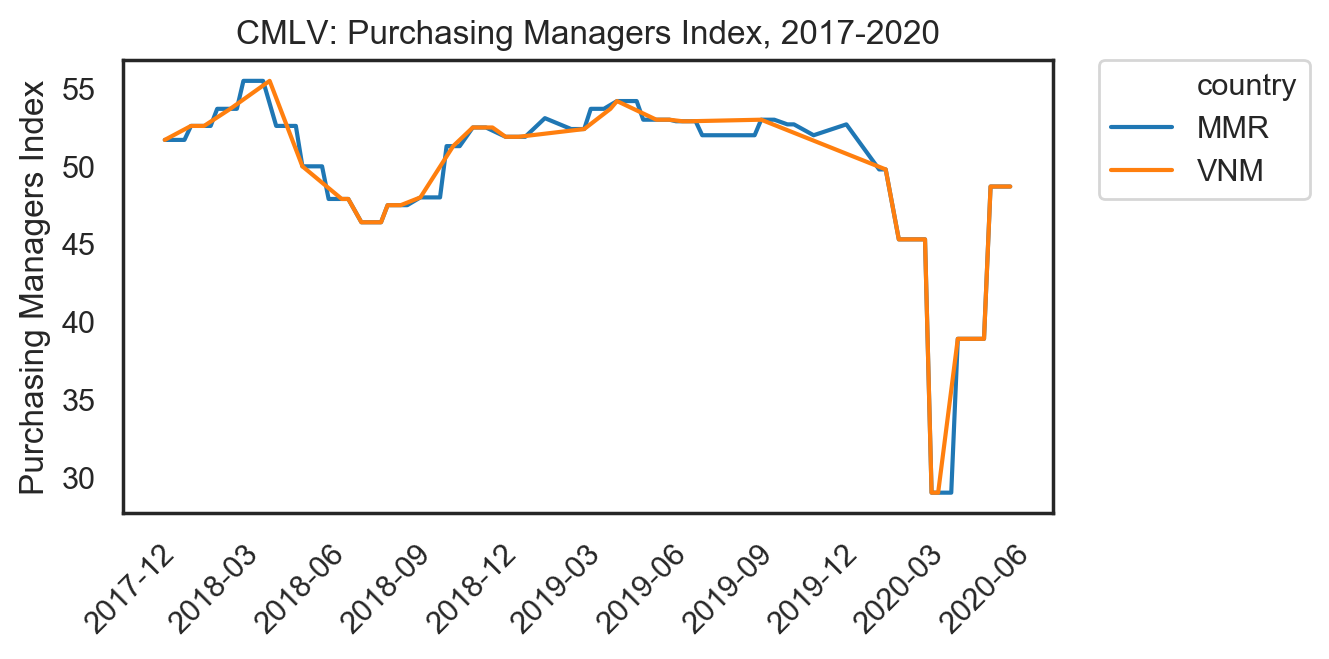

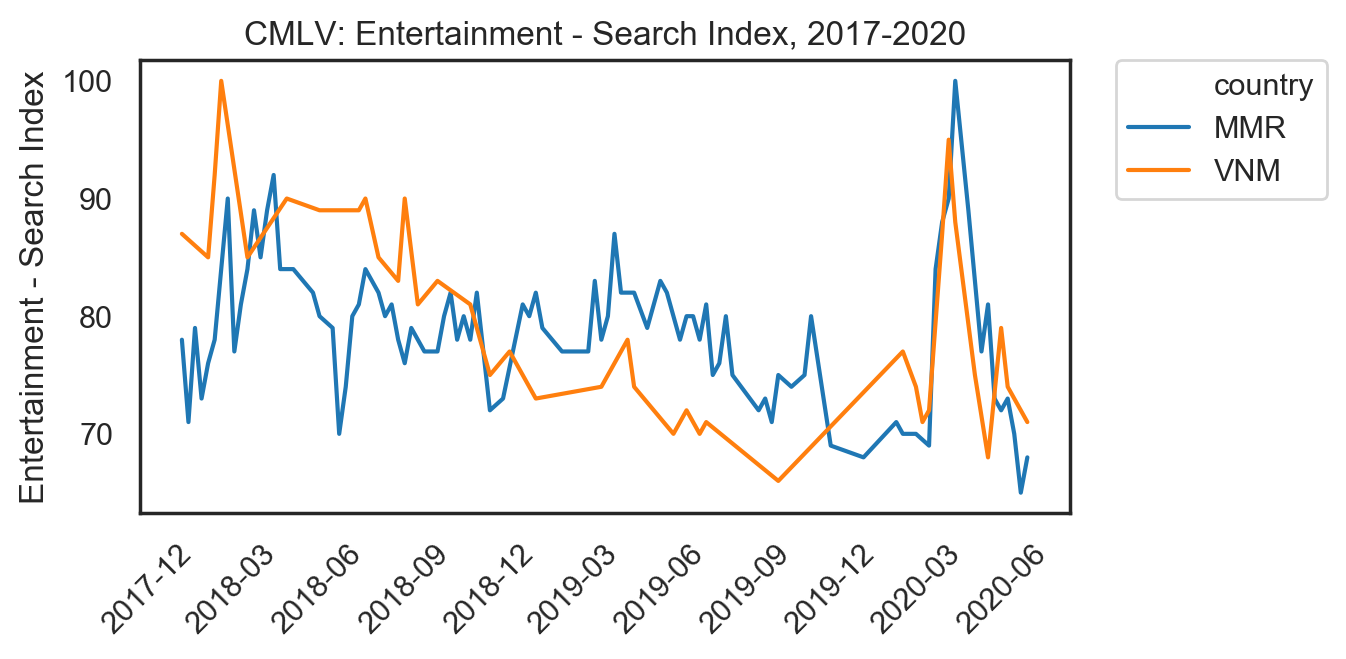

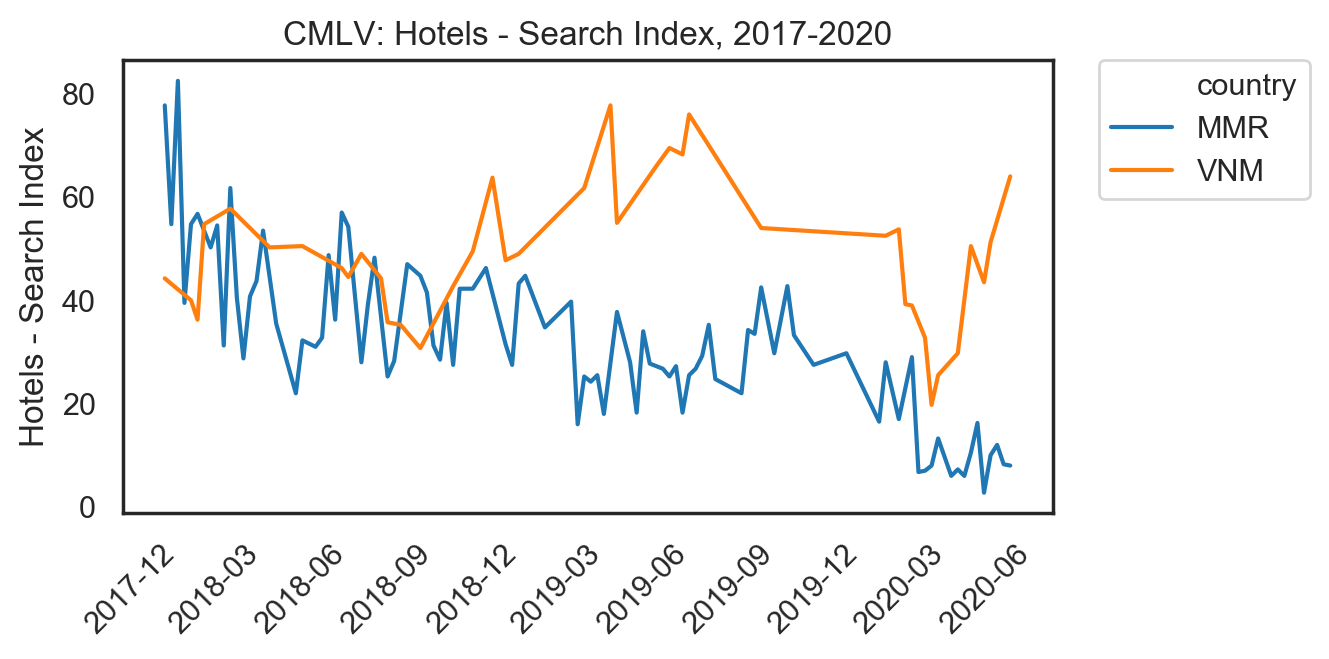

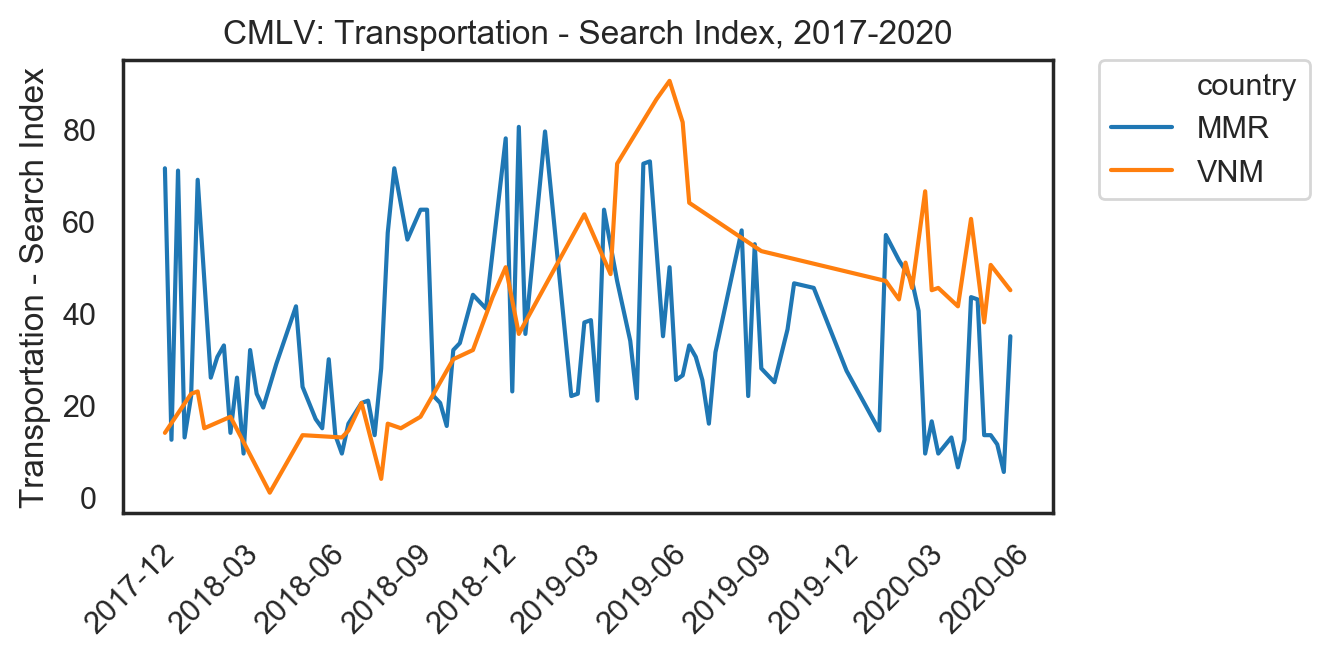

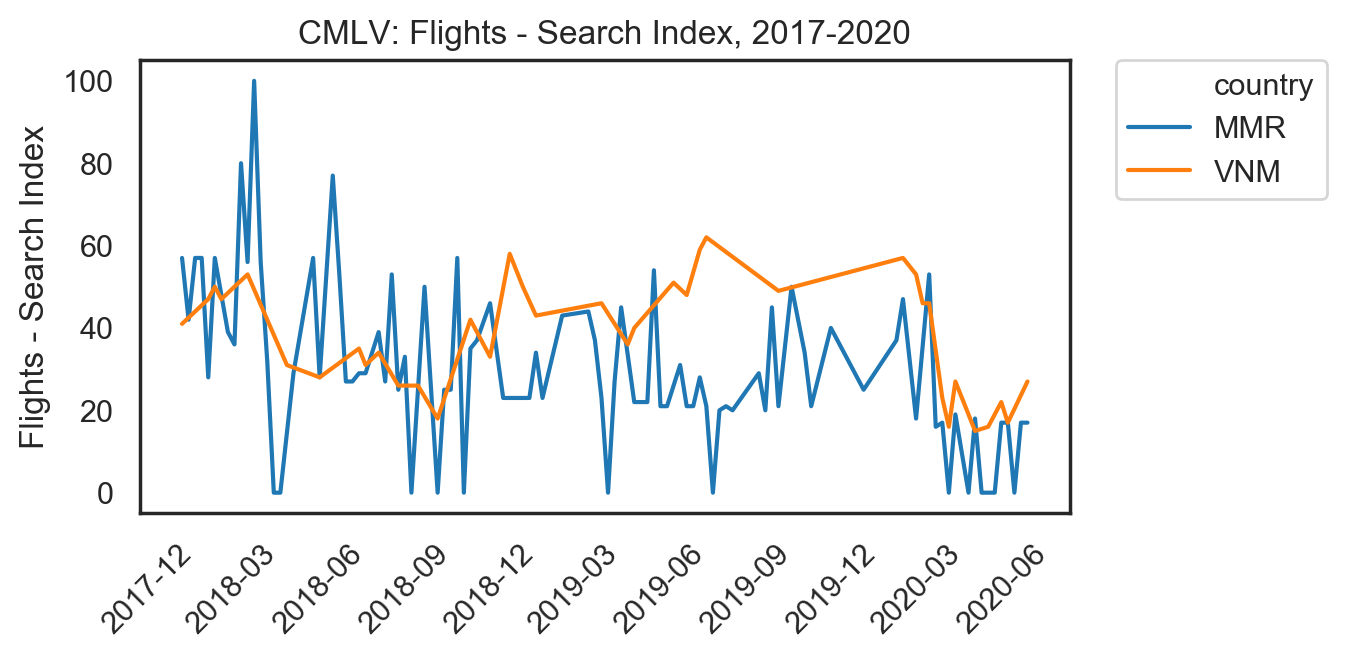

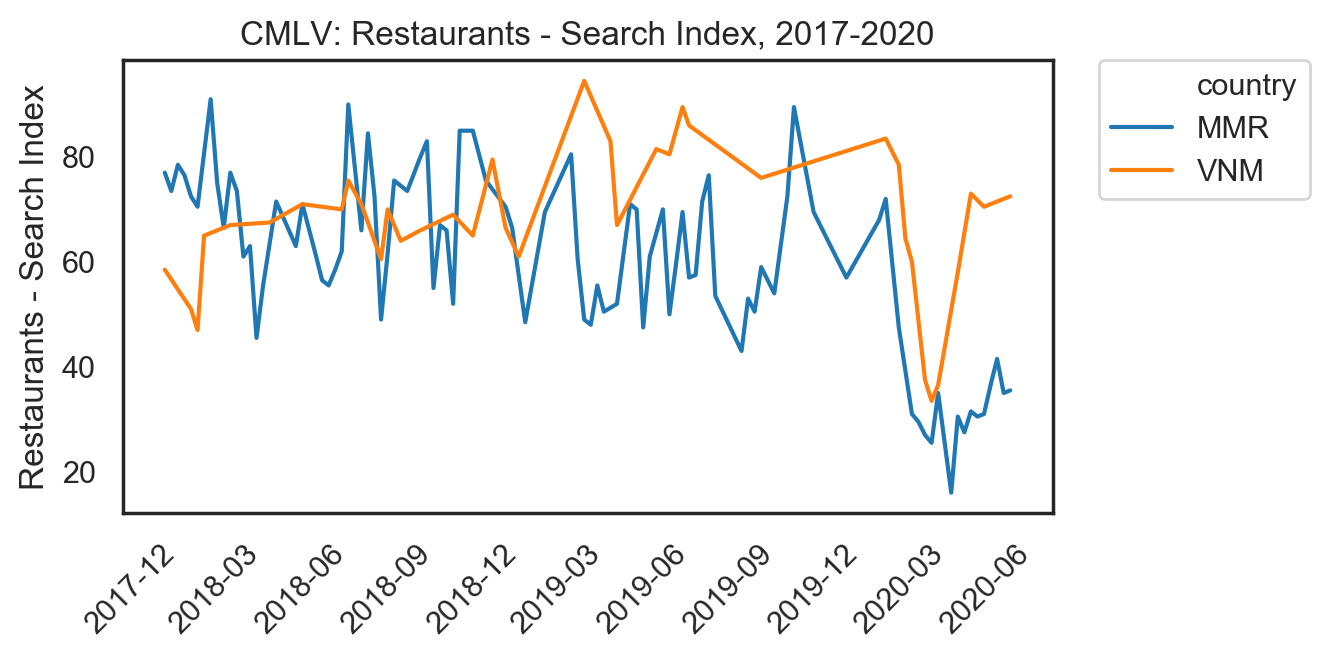

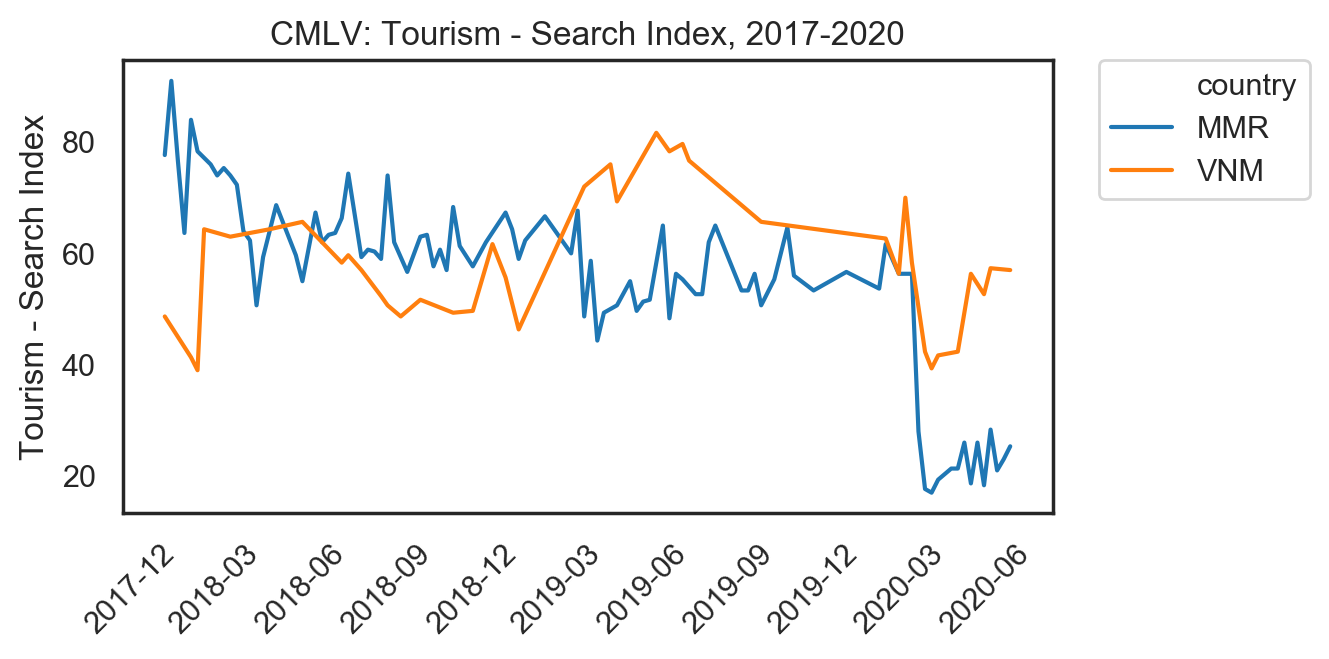

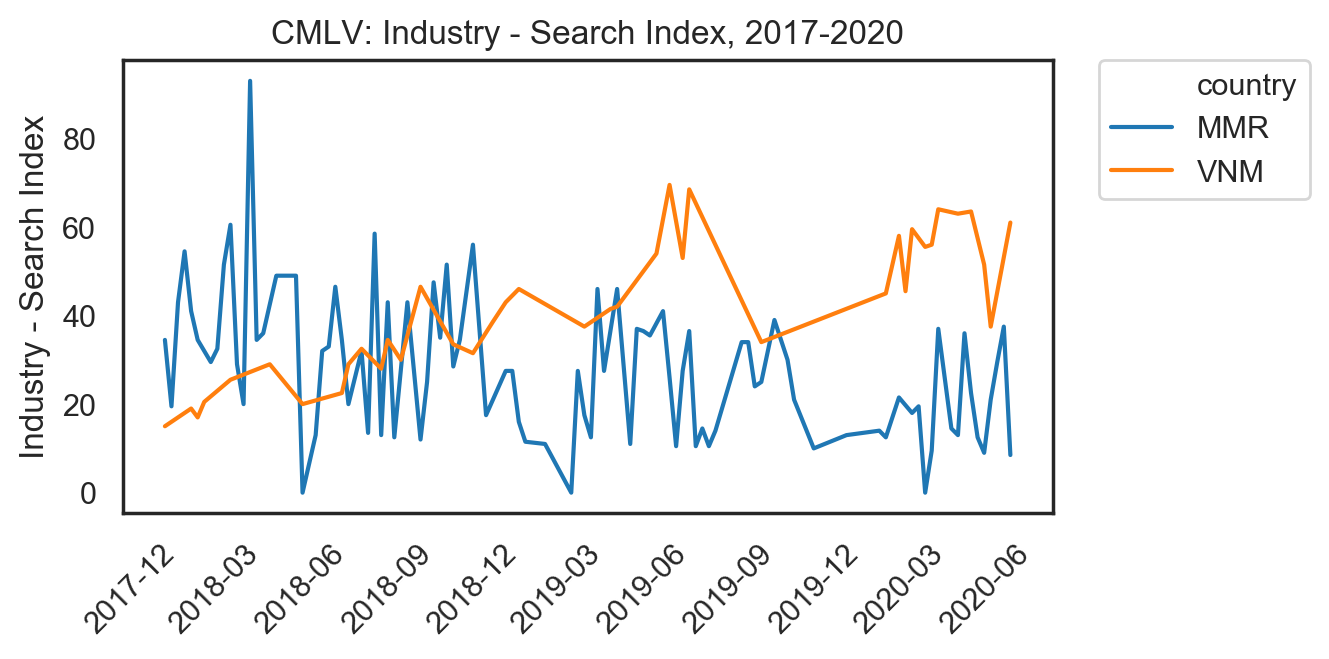

In [37]:
region = cmlv
reg_str = "CMLV"
plot_vars(region, reg_str)

#### East Asia

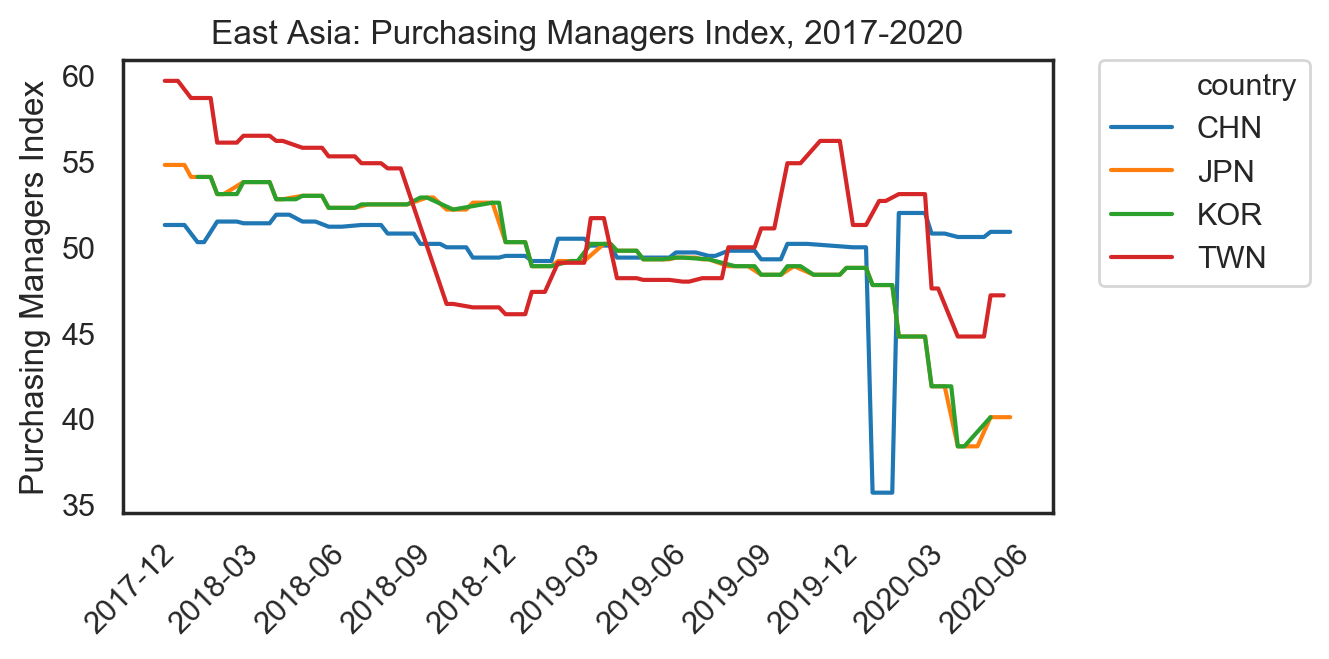

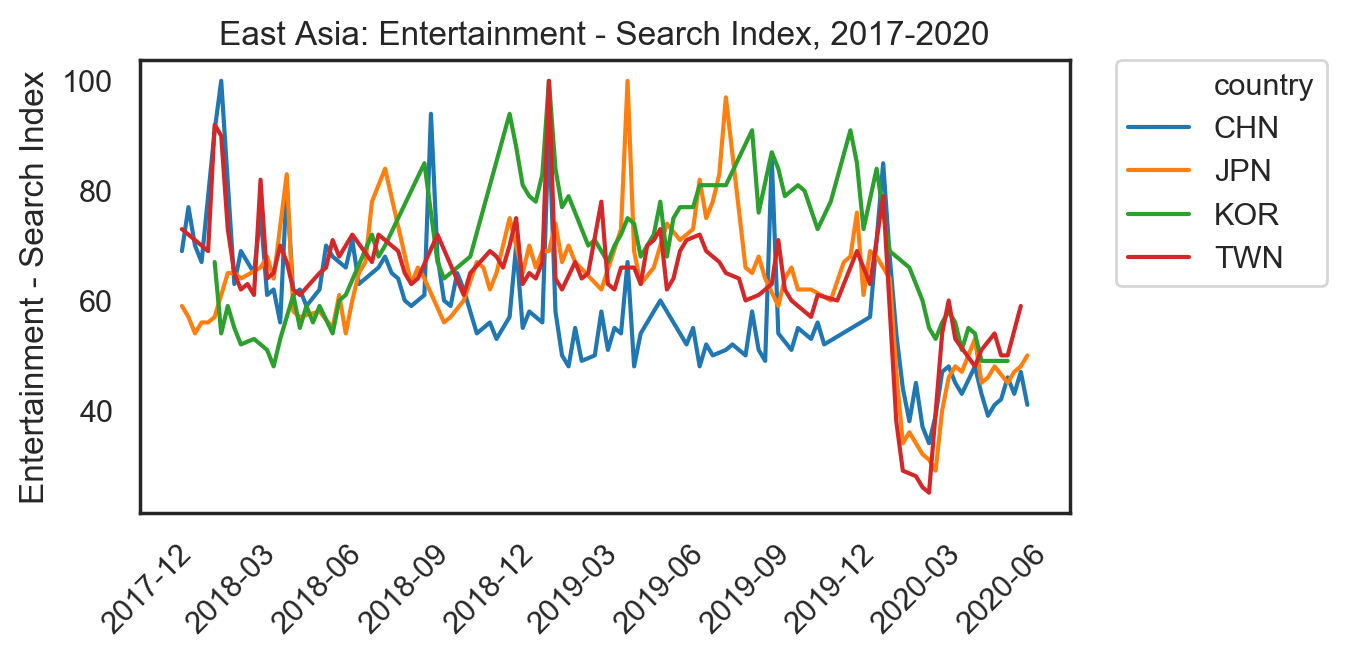

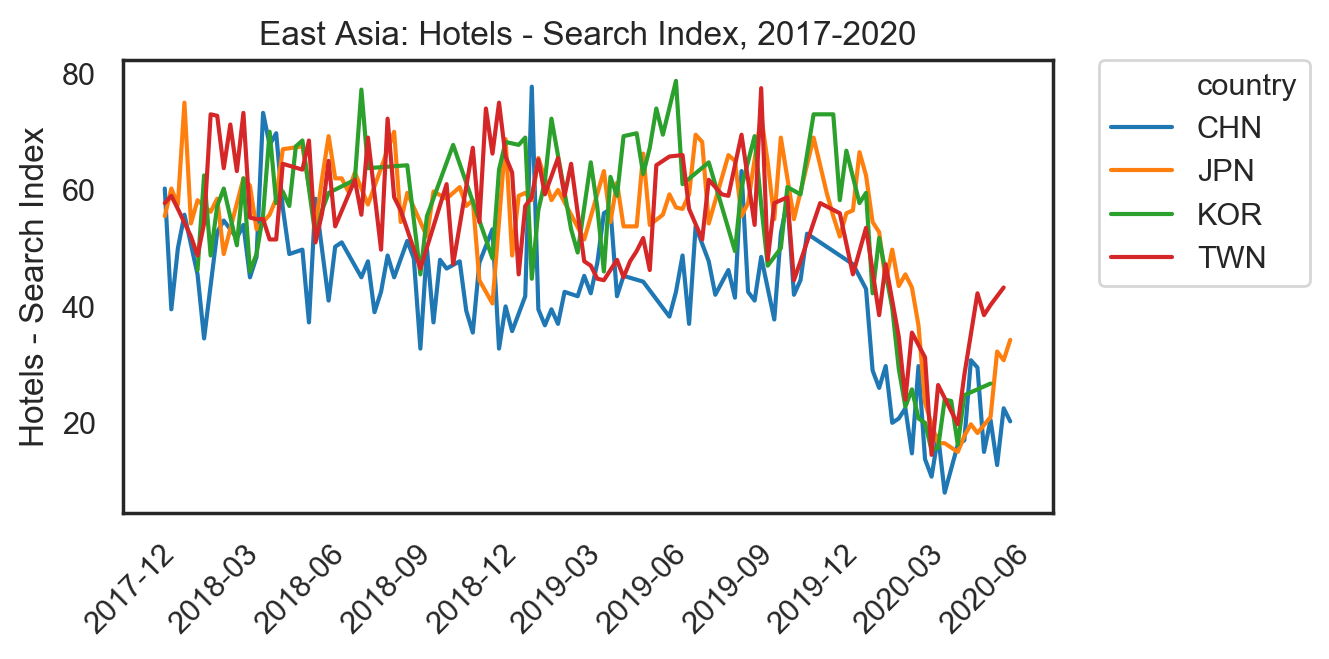

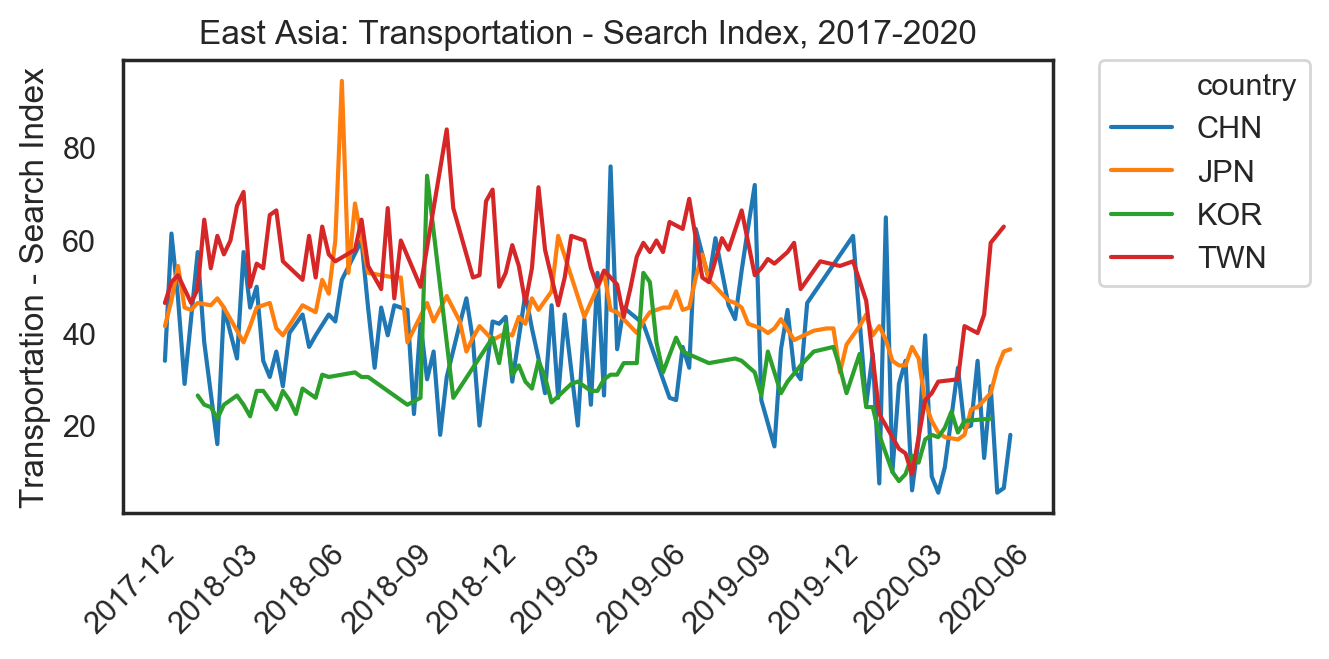

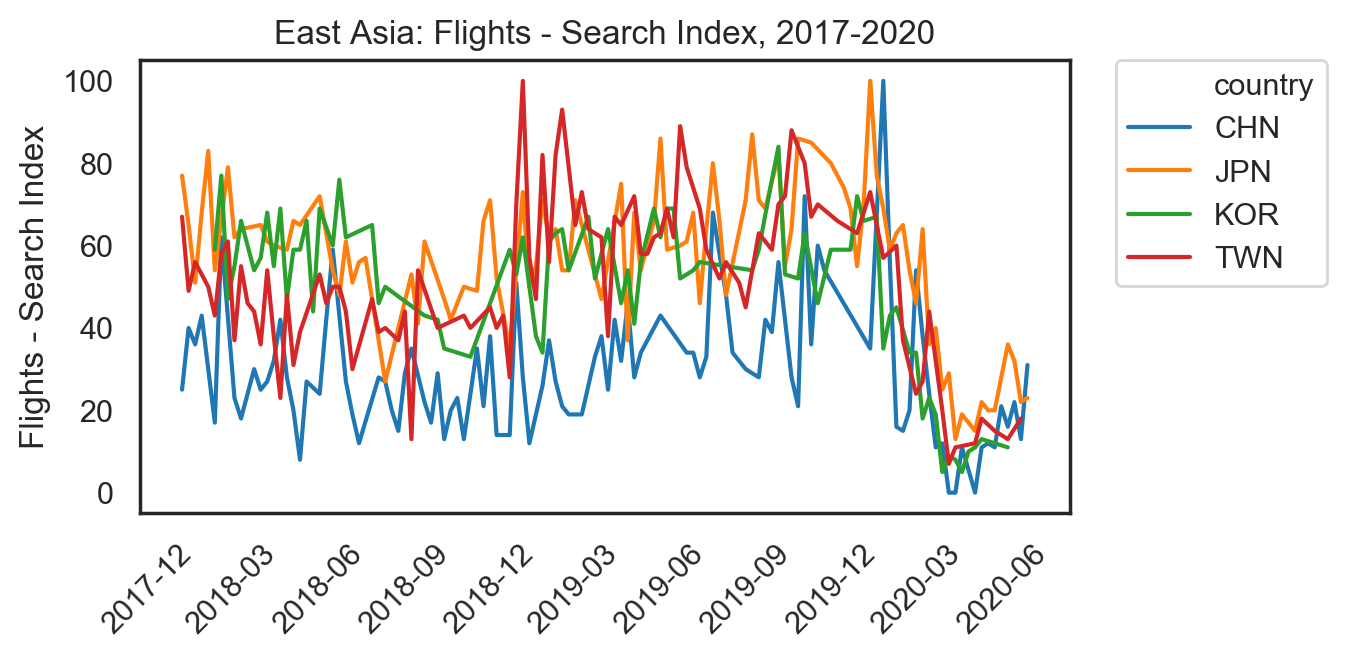

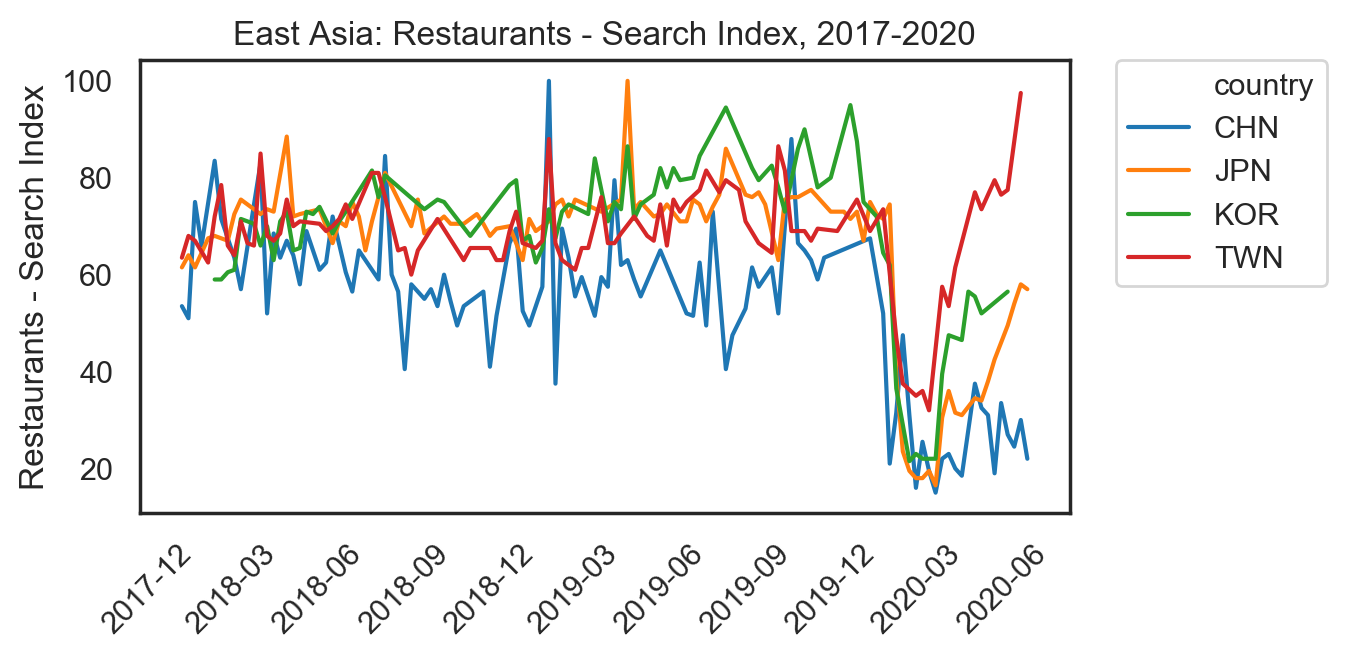

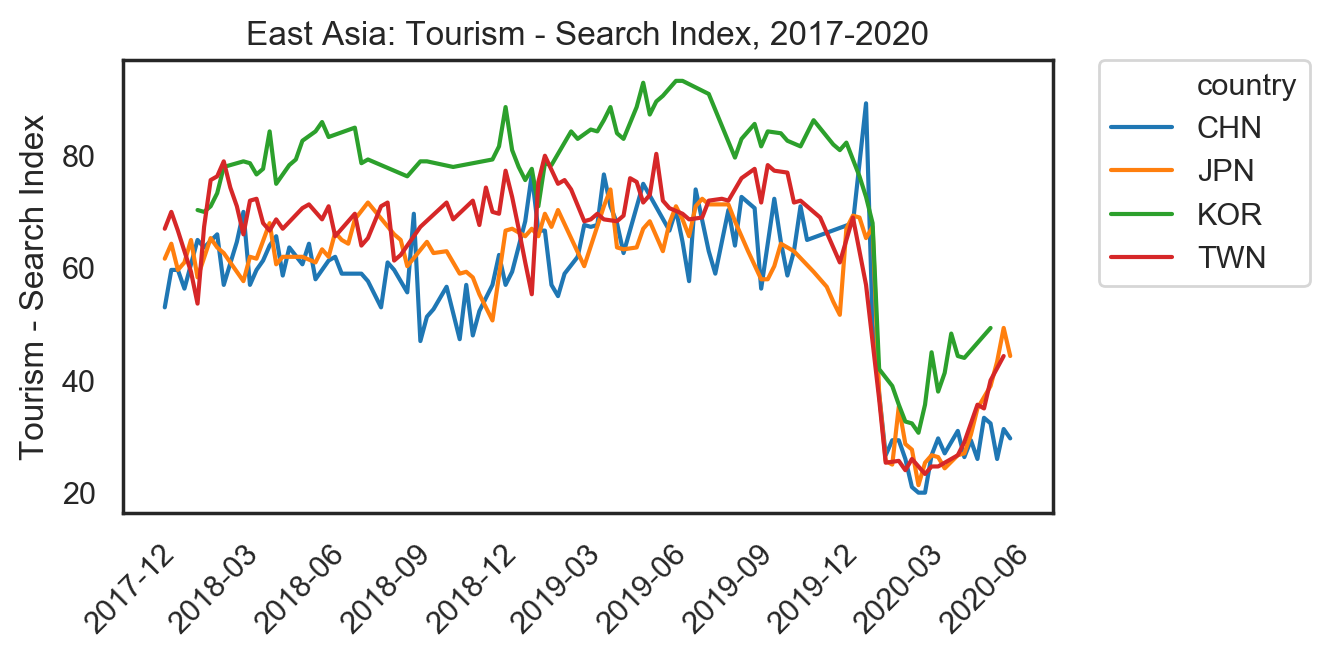

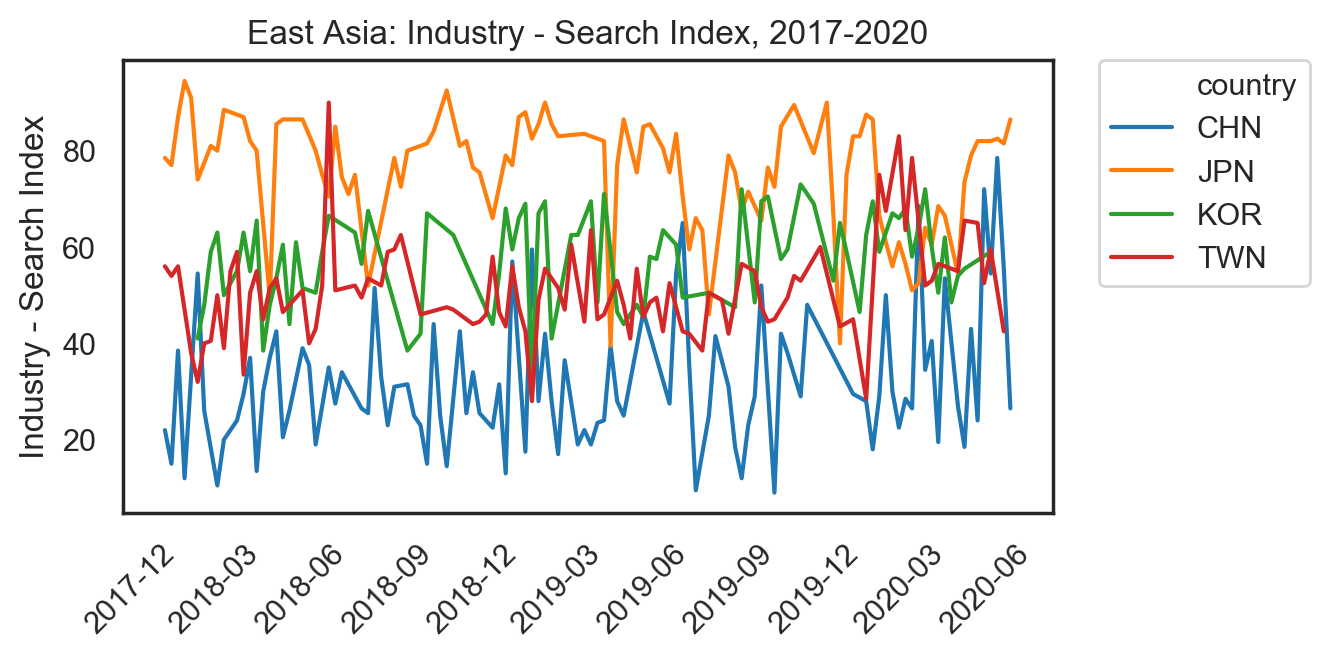

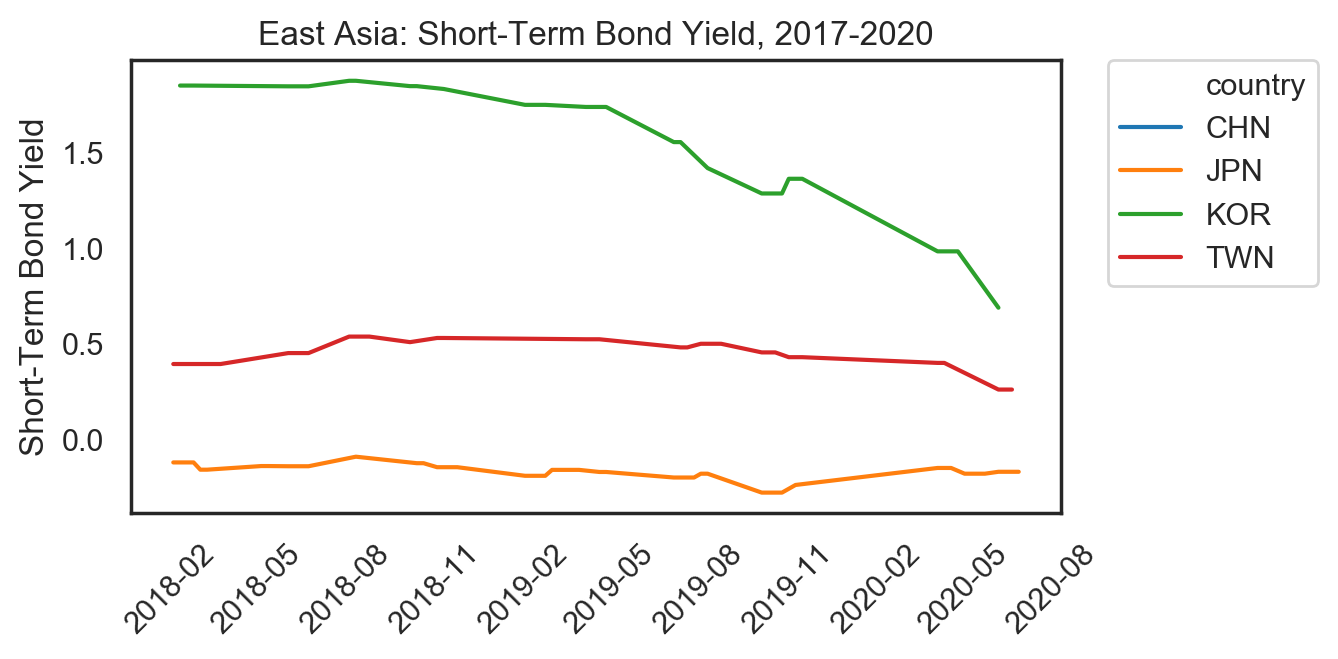

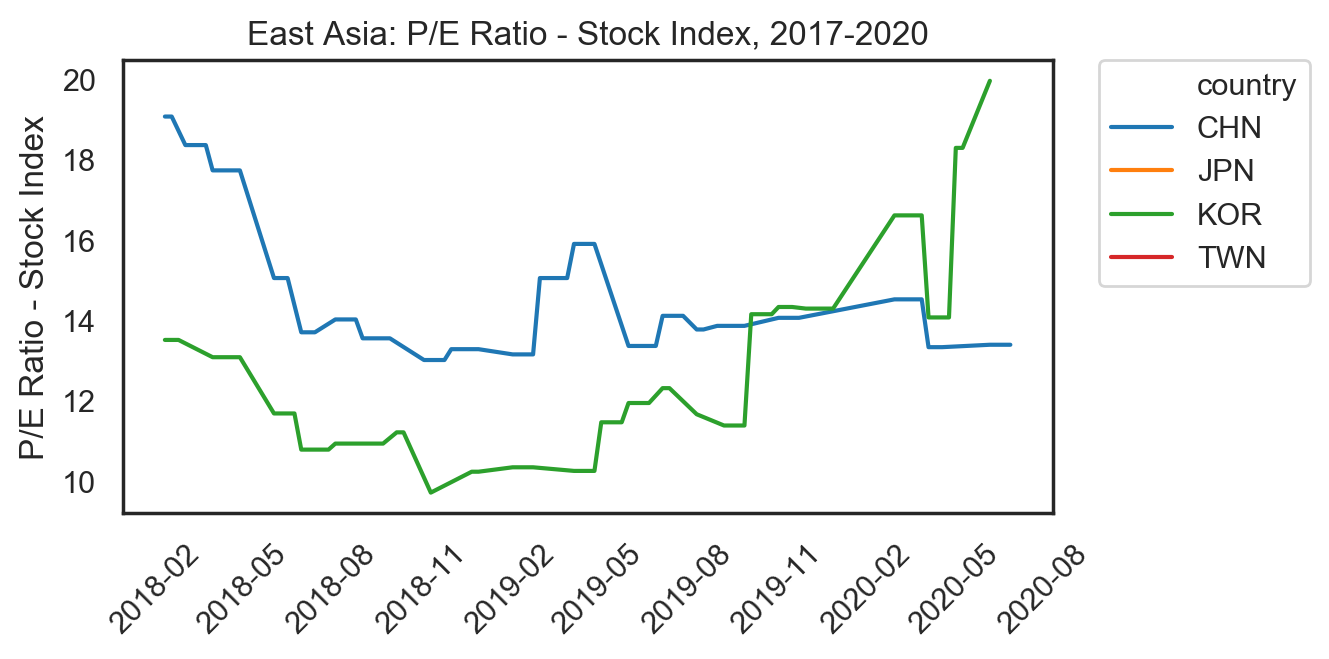

In [38]:
region = east
reg_str = "East Asia"
plot_vars(region, reg_str)

#### Pacific and Oceania

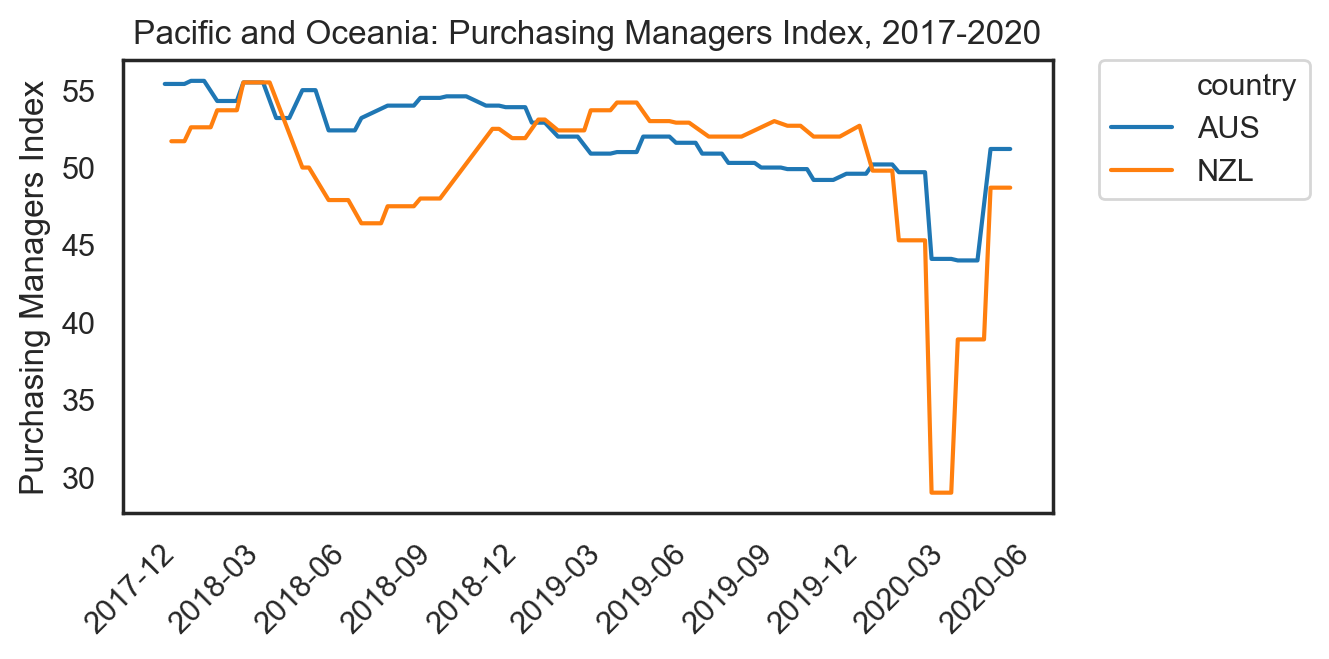

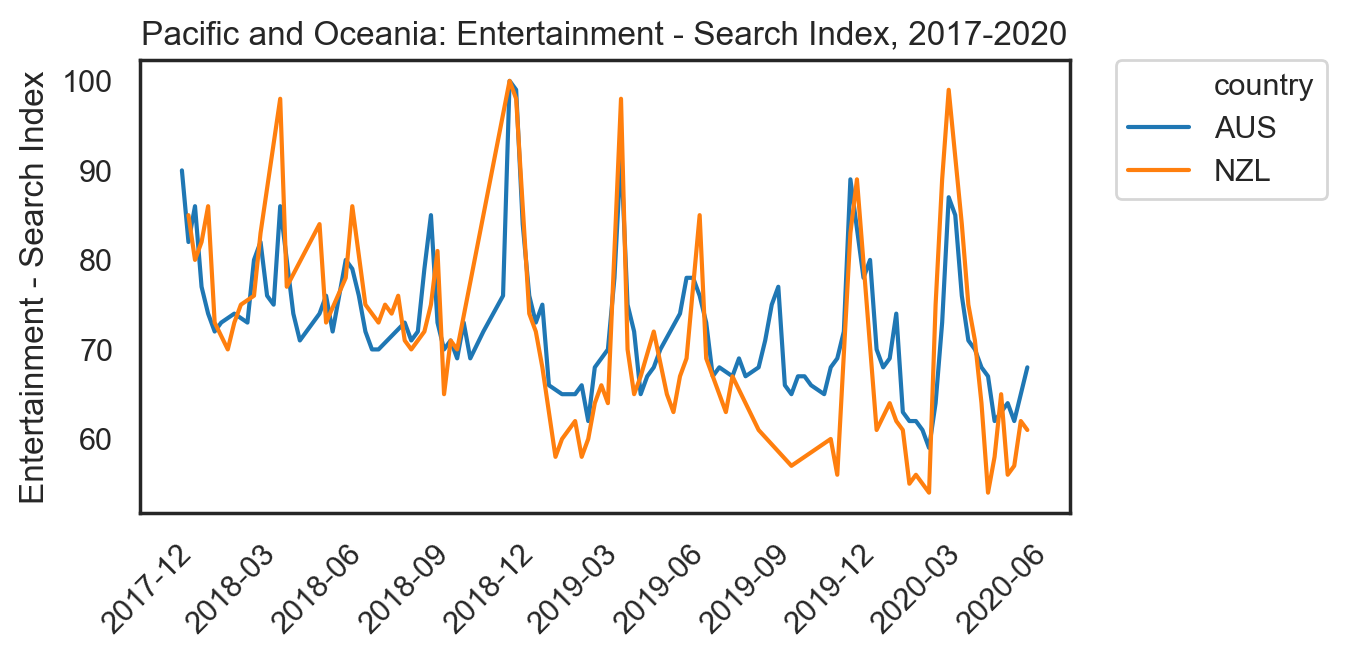

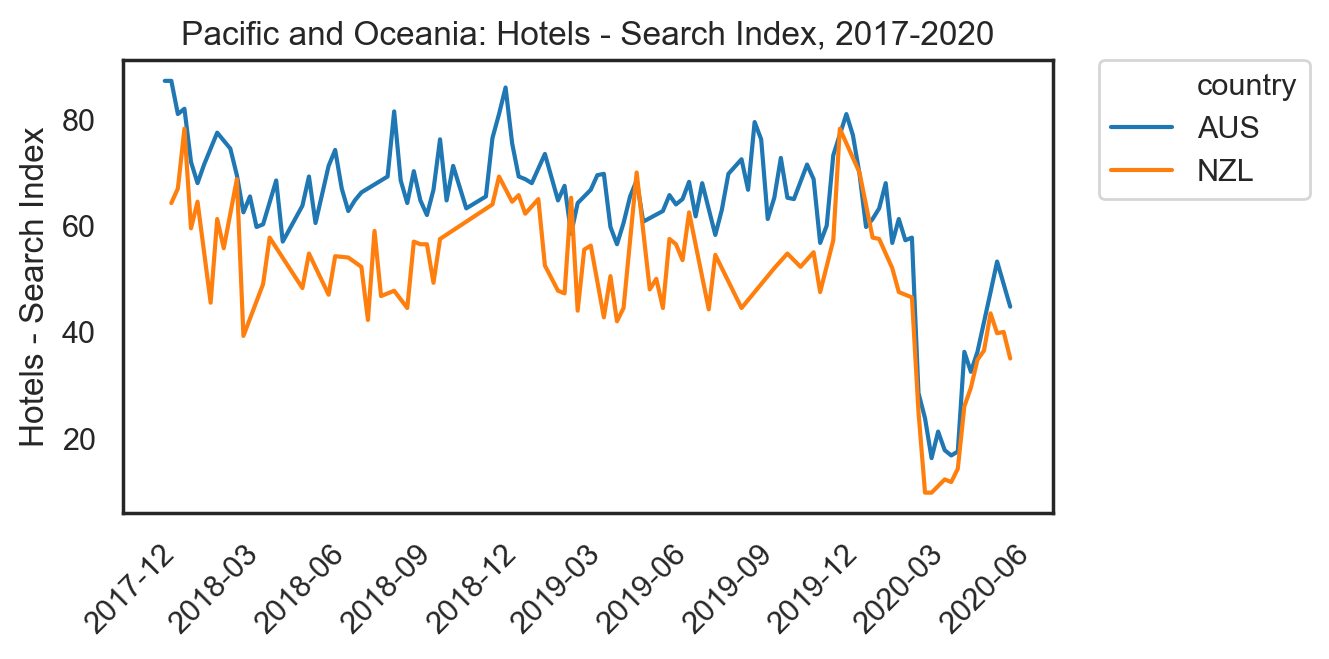

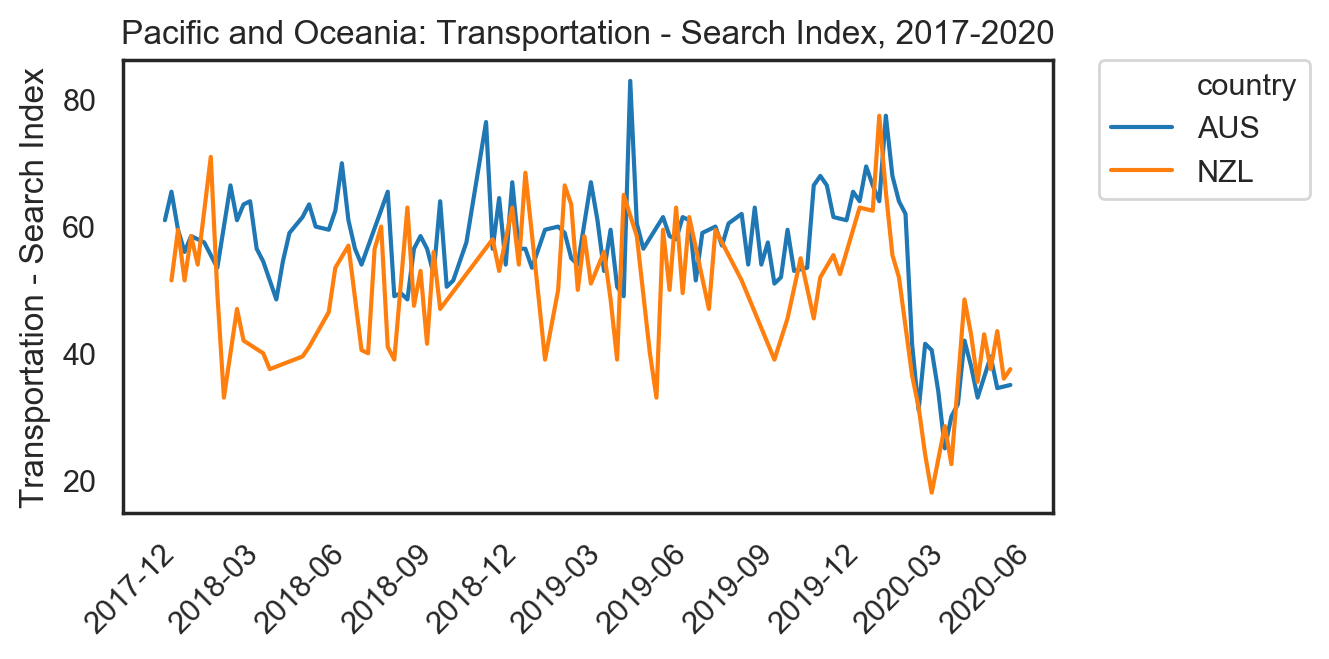

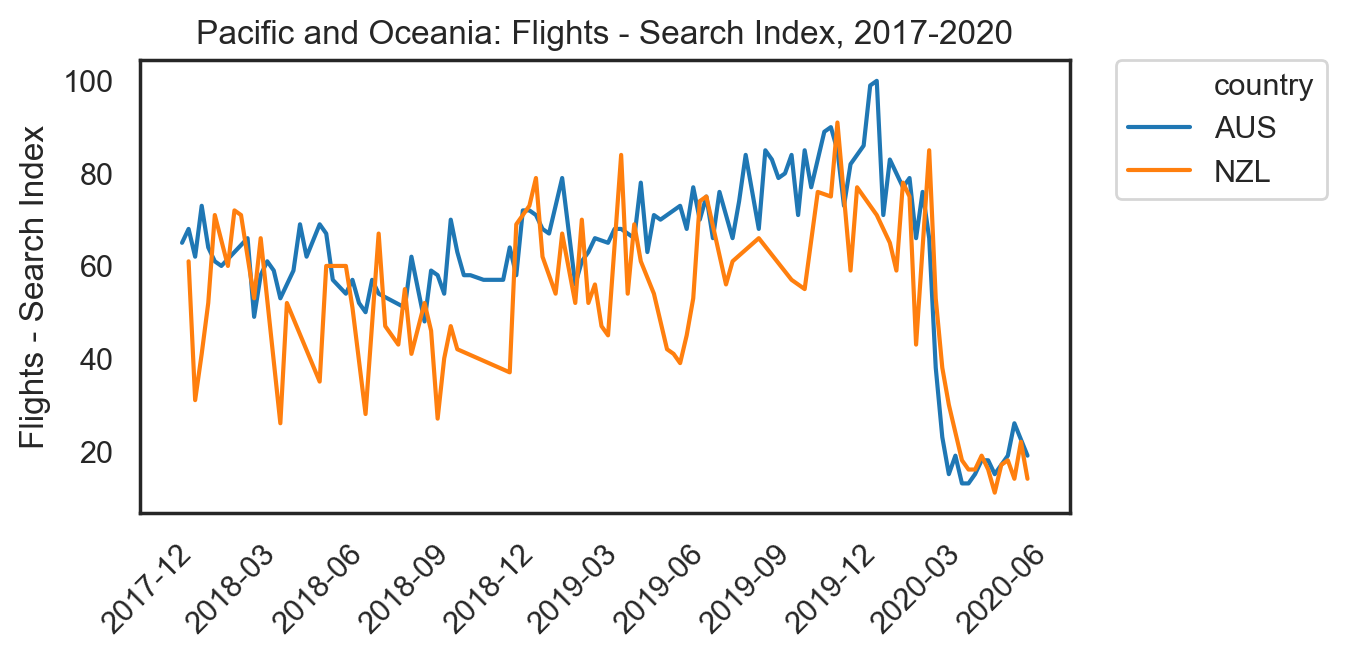

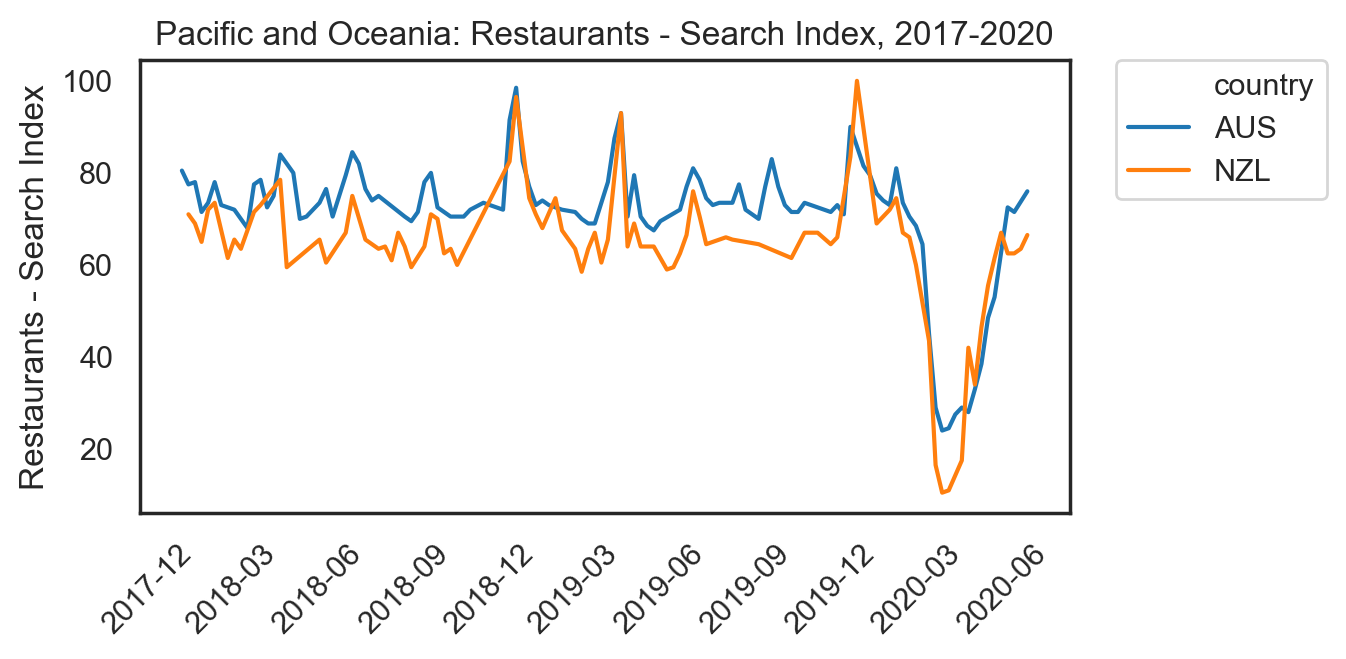

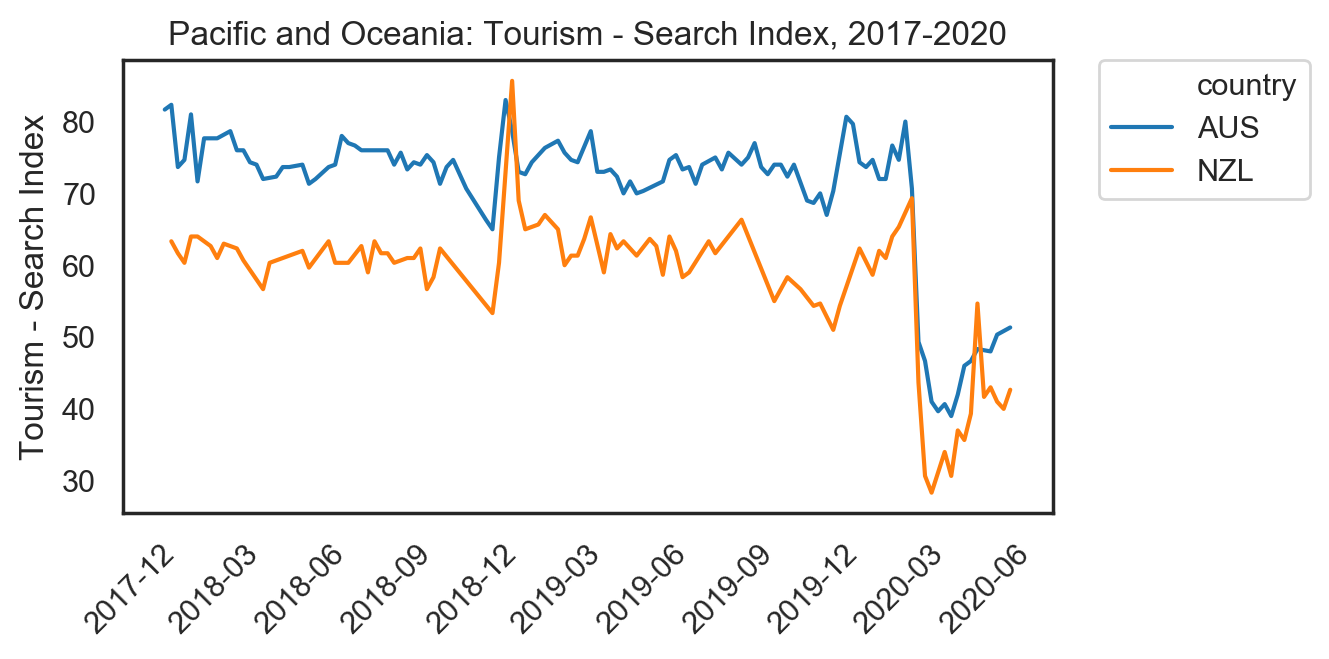

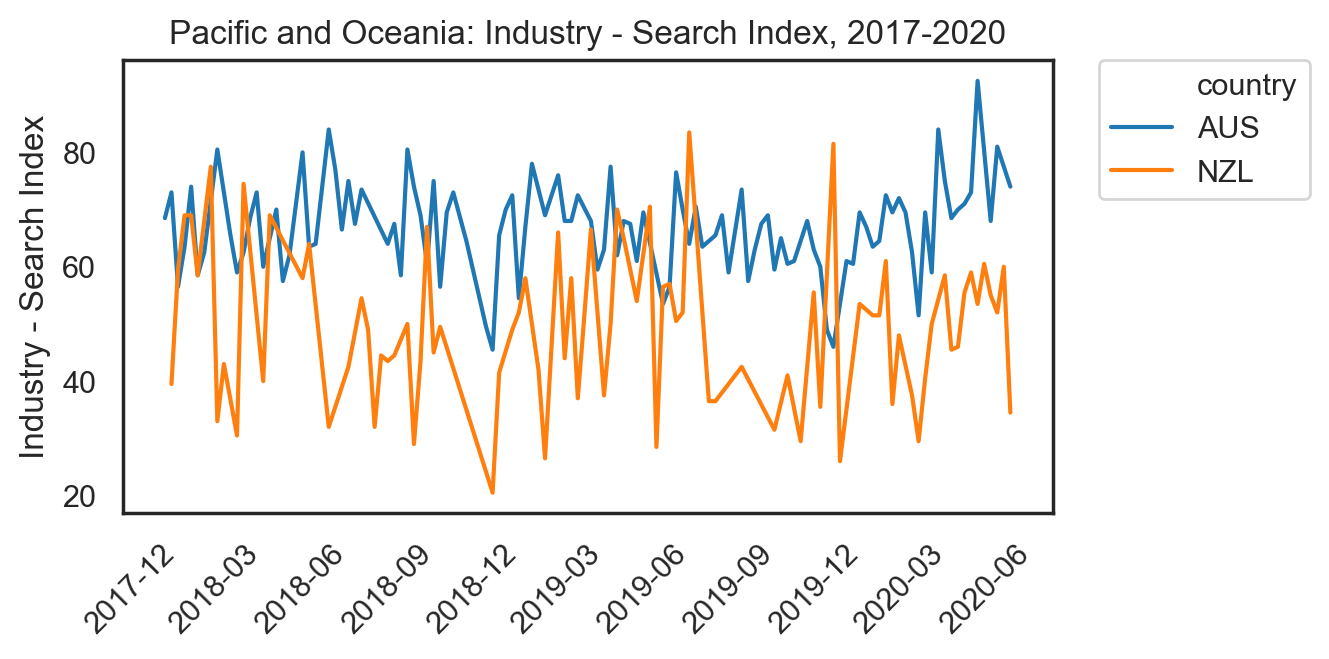

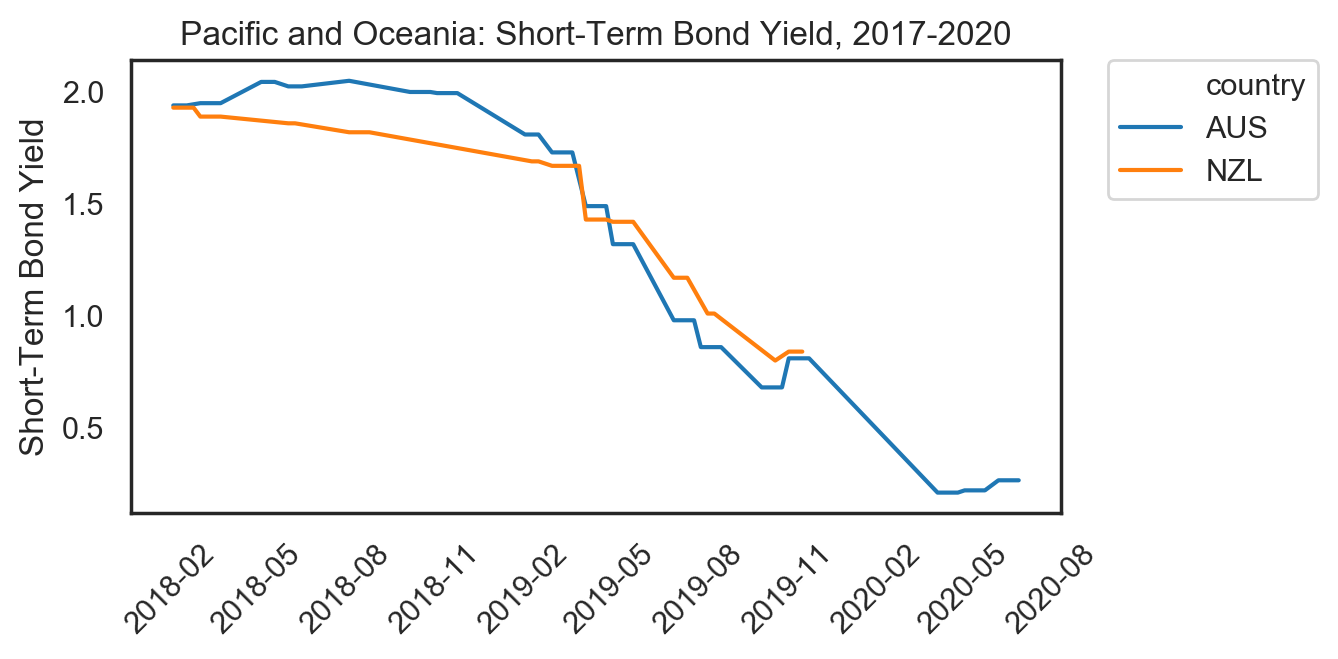

In [39]:
region = pac
reg_str = "Pacific and Oceania"
plot_vars(region, reg_str)

# Time Series Analysis

## Stationarity Checks

Here, we perform basic tests on the forecasted variable, PMI. We perform graphical analysis on the rolling mean and rolling standard deviation to confirm these visually. Moreover, we use unit root tests such as the Augmented Dickey-Fuller and Kwiatkowski–Phillips–Schmidt–Shin (KPSS). 

### ASEAN - 4

For all ASEAN-4 countries, we see that all have the existence of a unit root - apart from the Philippines. 

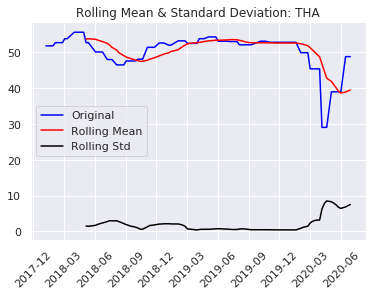

Results of Dickey-Fuller Test:
Test Statistic                 -1.952733
p-value                         0.307674
#Lags Used                      9.000000
Number of Observations Used    80.000000
Critical Value (1%)            -3.514869
Critical Value (5%)            -2.898409
Critical Value (10%)           -2.586439
dtype: float64
Results of KPSS Test:
Test Statistic            0.127265
p-value                   0.084694
Lags Used                12.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64


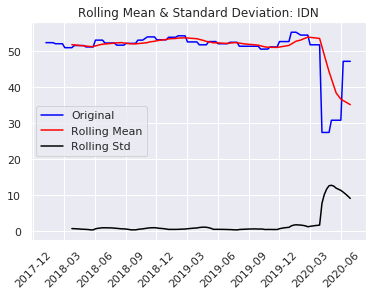

Results of Dickey-Fuller Test:
Test Statistic                  -1.870093
p-value                          0.346259
#Lags Used                      12.000000
Number of Observations Used    110.000000
Critical Value (1%)             -3.491245
Critical Value (5%)             -2.888195
Critical Value (10%)            -2.580988
dtype: float64
Results of KPSS Test:
Test Statistic            0.138269
p-value                   0.064316
Lags Used                13.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64


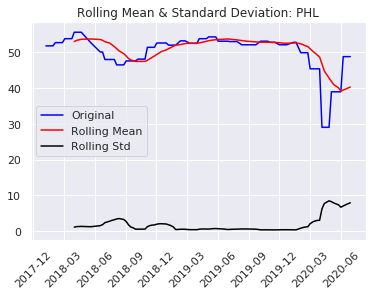

Results of Dickey-Fuller Test:
Test Statistic                 -4.196284
p-value                         0.000669
#Lags Used                      9.000000
Number of Observations Used    92.000000
Critical Value (1%)            -3.503515
Critical Value (5%)            -2.893508
Critical Value (10%)           -2.583824
dtype: float64
Results of KPSS Test:
Test Statistic            0.132837
p-value                   0.074376
Lags Used                13.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64


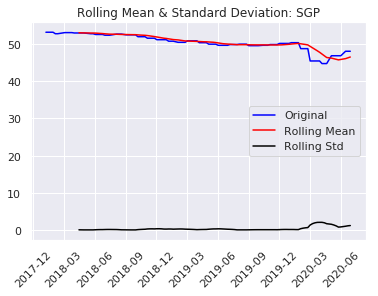

Results of Dickey-Fuller Test:
Test Statistic                   0.134630
p-value                          0.968347
#Lags Used                      12.000000
Number of Observations Used    100.000000
Critical Value (1%)             -3.497501
Critical Value (5%)             -2.890906
Critical Value (10%)            -2.582435
dtype: float64
Results of KPSS Test:
Test Statistic            0.072257
p-value                   0.100000
Lags Used                13.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64


In [49]:
countries = ['THA', 'IDN', 'PHL', 'SGP']

for country in countries:
    st_check(df, country, 'pmi')

We take the differenced PMI and run the test once again for Thailand, Indonesia, and Singapore.

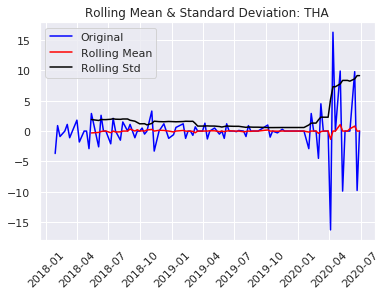

Results of Dickey-Fuller Test:
Test Statistic                 -4.972256
p-value                         0.000025
#Lags Used                      7.000000
Number of Observations Used    81.000000
Critical Value (1%)            -3.513790
Critical Value (5%)            -2.897943
Critical Value (10%)           -2.586191
dtype: float64
Results of KPSS Test:
Test Statistic            0.074692
p-value                   0.100000
Lags Used                12.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64


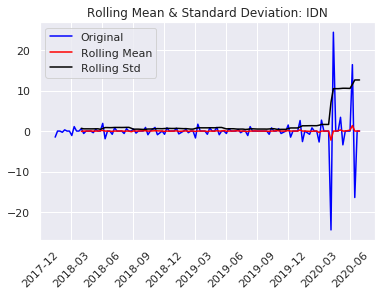

Results of Dickey-Fuller Test:
Test Statistic                  -5.215475
p-value                          0.000008
#Lags Used                      13.000000
Number of Observations Used    108.000000
Critical Value (1%)             -3.492401
Critical Value (5%)             -2.888697
Critical Value (10%)            -2.581255
dtype: float64
Results of KPSS Test:
Test Statistic            0.058464
p-value                   0.100000
Lags Used                13.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64


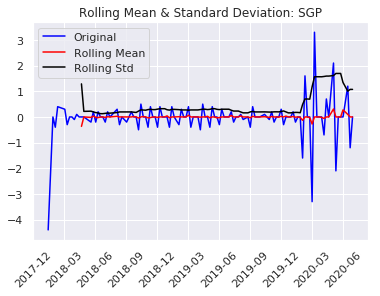

Results of Dickey-Fuller Test:
Test Statistic                  -4.970003
p-value                          0.000025
#Lags Used                      10.000000
Number of Observations Used    101.000000
Critical Value (1%)             -3.496818
Critical Value (5%)             -2.890611
Critical Value (10%)            -2.582277
dtype: float64
Results of KPSS Test:
Test Statistic            0.125968
p-value                   0.087097
Lags Used                13.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64


In [50]:
countries = ['THA', 'IDN', 'SGP']

for country in countries:
    st_check(df, country, 'pmi_df', diff=True)

# Time Series Modeling

## Baseline ARIMA

### ASEAN - 4

We now determine the optimal number of lags. First, we use graphical methods such as the ACF and PACF. 

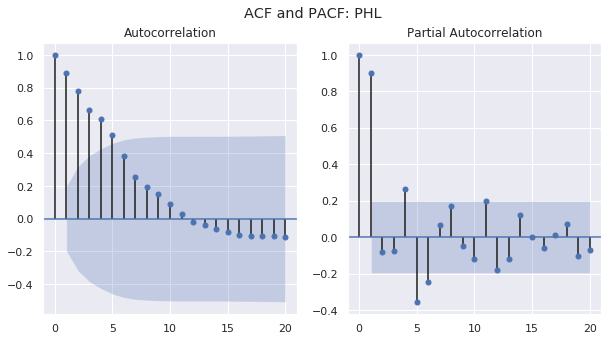

In [77]:
tr_start,tr_end = '2018-01-07','2020-05-31'
te_start,te_end = '2020-06-07','2020-06-28'

plot_corr(df, 'PHL', tr_start, tr_end, te_start, te_end)

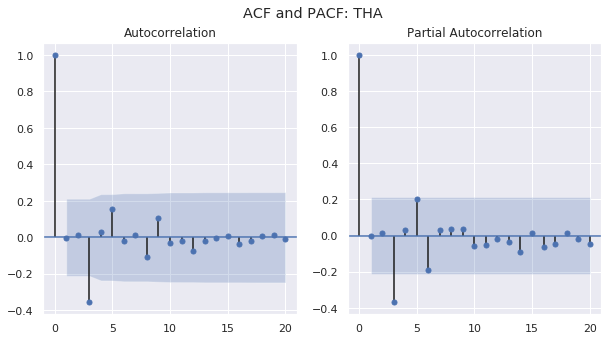

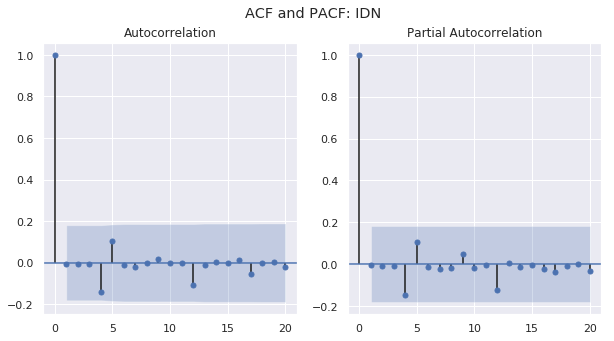

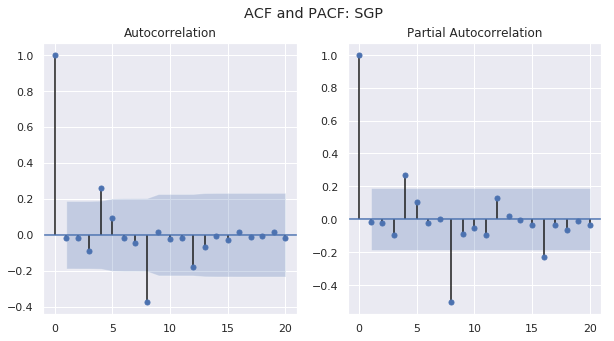

In [78]:
countries = ['THA', 'IDN', 'SGP']

for country in countries:
    plot_corr(df, country, tr_start, tr_end, te_start, te_end, diff=True)

We select the best ARMA(p,q) order based on the AIC and BIC. 

In [82]:
countries = ['THA', 'IDN', 'PHL', 'SGP']

for country in countries:
    resDiff = sm.tsa.arma_order_select_ic(df[df.country==country]['pmi'], max_ar=5, max_ma=5, ic='aic', trend='c')
    print('ARMA(p,q) =',resDiff['aic_min_order'],'is the best for country {}'.format(country))

ARMA(p,q) = (5, 5) is the best for country THA
ARMA(p,q) = (4, 5) is the best for country IDN
ARMA(p,q) = (5, 5) is the best for country PHL
ARMA(p,q) = (1, 4) is the best for country SGP


We now fit the baseline ARIMA models for each country based on the best lag order as determined in the previous step. As seen in the 10-step ahead forecasts, ARIMA does not have a good fit. This is expected given the external shocks from the recent pandemic.

#### Thailand

                           Statespace Model Results                           
Dep. Variable:                    pmi   No. Observations:                   87
Model:               SARIMAX(5, 1, 5)   Log Likelihood                -169.570
Date:                Mon, 20 Jul 2020   AIC                            361.140
Time:                        12:10:44   BIC                            387.343
Sample:                             0   HQIC                           371.646
                                 - 87                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.4640      1.676     -0.874      0.382      -4.748       1.821
ar.L2         -1.0178      2.761     -0.369      0.712      -6.430       4.394
ar.L3         -1.2385      2.162     -0.573      0.5

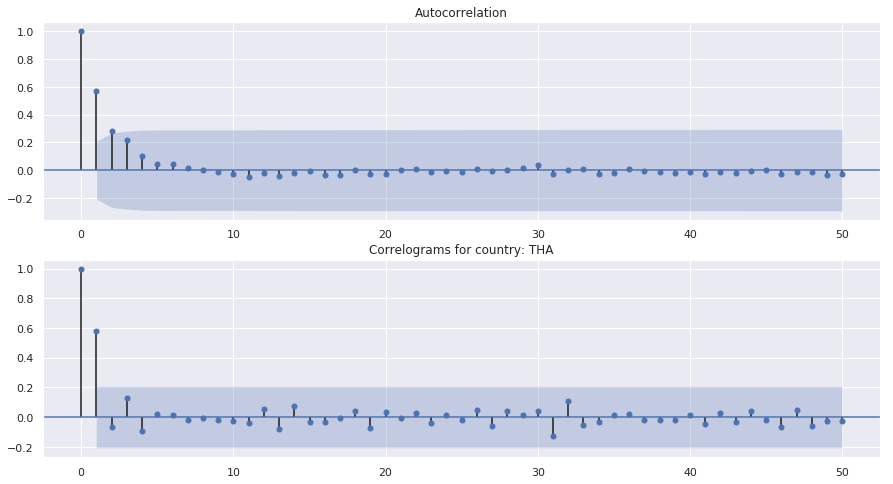

ARIMA model MSE for 10-step ahead forecast:68.2418948035091


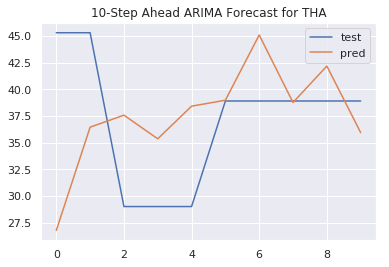

In [228]:
fit_arima('THA', tr_start, tr_end, te_start, te_end, order = (5,1,5))

#### Indonesia

                           Statespace Model Results                           
Dep. Variable:                    pmi   No. Observations:                  119
Model:               SARIMAX(4, 1, 5)   Log Likelihood                -254.533
Date:                Mon, 20 Jul 2020   AIC                            529.067
Time:                        12:11:17   BIC                            556.252
Sample:                             0   HQIC                           540.097
                                - 119                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6406     17.104     -0.037      0.970     -34.163      32.882
ar.L2         -0.5038     15.182     -0.033      0.974     -30.260      29.252
ar.L3         -0.4914     14.765     -0.033      0.9

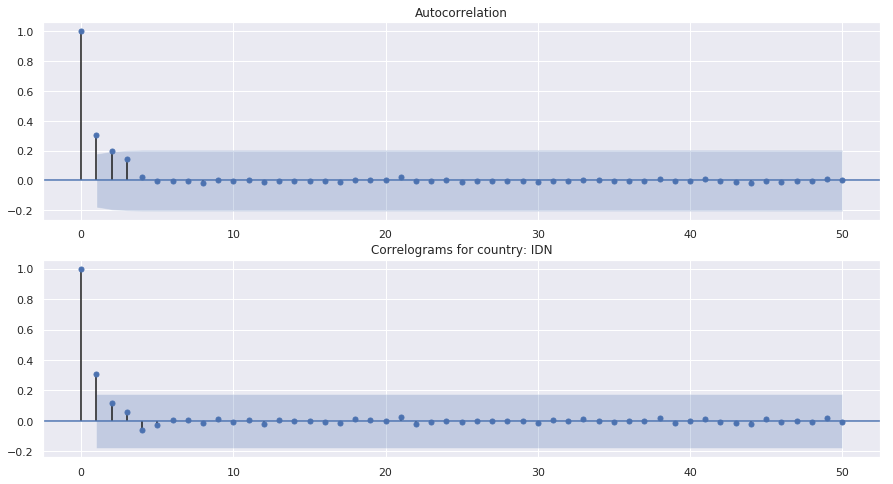

ARIMA model MSE for 10-step ahead forecast:390.00975548459485


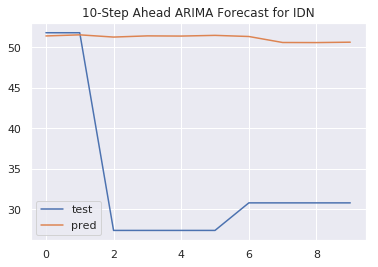

In [229]:
fit_arima('IDN', tr_start, tr_end, te_start, te_end, order = (4,1,5))

#### Philippines

                           Statespace Model Results                           
Dep. Variable:                    pmi   No. Observations:                   98
Model:               SARIMAX(5, 0, 5)   Log Likelihood                -188.784
Date:                Mon, 20 Jul 2020   AIC                            399.568
Time:                        12:11:35   BIC                            427.308
Sample:                             0   HQIC                           410.764
                                 - 98                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4576      0.231     -1.981      0.048      -0.910      -0.005
ar.L2          0.2088      0.198      1.052      0.293      -0.180       0.598
ar.L3          0.2561      0.199      1.288      0.1

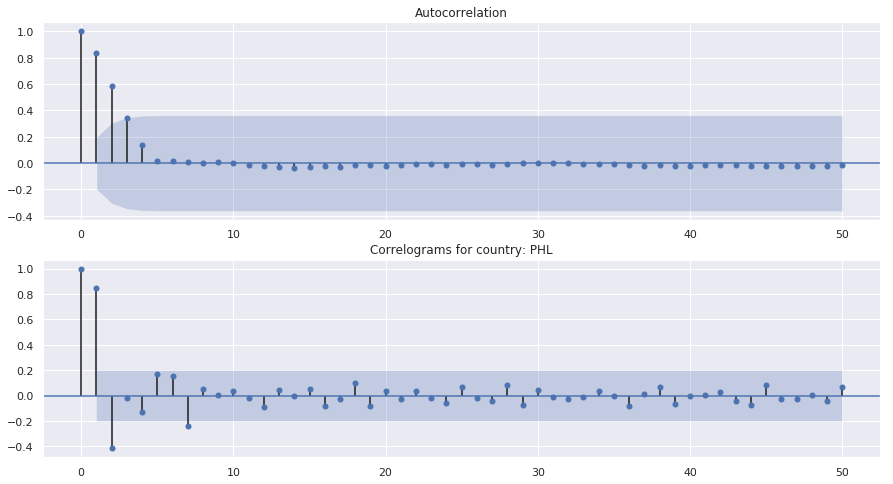

ARIMA model MSE for 10-step ahead forecast:164.77040831387106


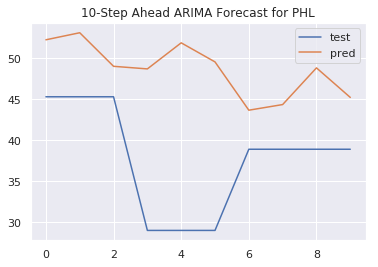

In [230]:
fit_arima('PHL', tr_start, tr_end, te_start, te_end, order = (5,0,5))

#### Singapore

                           Statespace Model Results                           
Dep. Variable:                    pmi   No. Observations:                   71
Model:               SARIMAX(1, 1, 4)   Log Likelihood                 -43.749
Date:                Mon, 27 Jul 2020   AIC                             99.497
Time:                        13:36:33   BIC                            112.544
Sample:                             0   HQIC                           104.645
                                 - 71                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7249      0.682     -1.062      0.288      -2.062       0.613
ma.L1          0.7122   1150.609      0.001      1.000   -2254.439    2255.863
ma.L2          0.0513    330.940      0.000      1.0

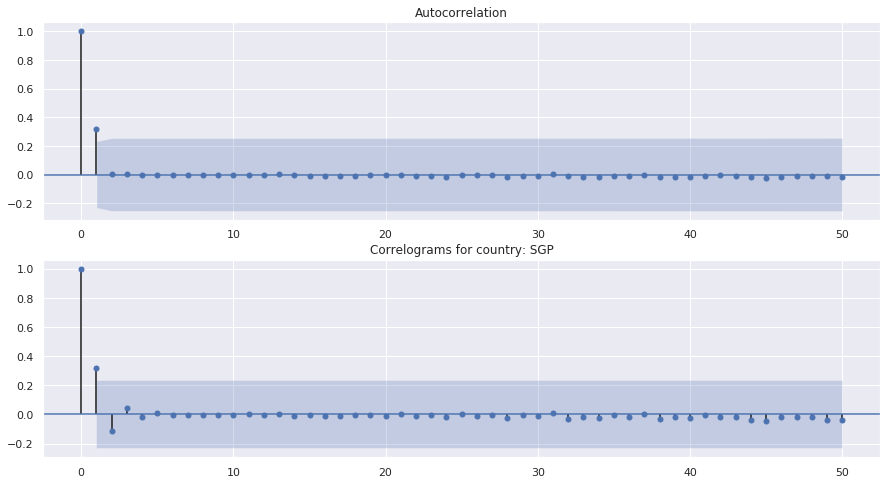

ARIMA model MSE for 10-step ahead forecast:3.552510517941363


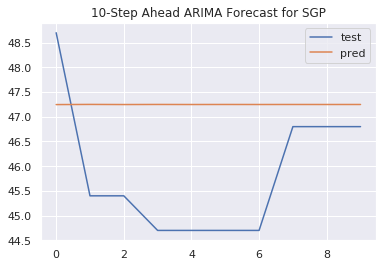

In [69]:
fit_arima('SGP', tr_start, tr_end, te_start, te_end, order = (1,1,4))

## ARIMAX

### ASEAN - 4

### Thailand

                           Statespace Model Results                           
Dep. Variable:                    pmi   No. Observations:                   61
Model:               SARIMAX(5, 1, 5)   Log Likelihood                -111.644
Date:                Mon, 27 Jul 2020   AIC                            251.288
Time:                        14:05:15   BIC                            279.134
Sample:                             0   HQIC                           262.027
                                 - 61                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
hotels          0.0771      0.049      1.576      0.115      -0.019       0.173
restaurants    -0.0287      0.043     -0.668      0.504      -0.113       0.056
tourism         0.0938      0.078      1.198    

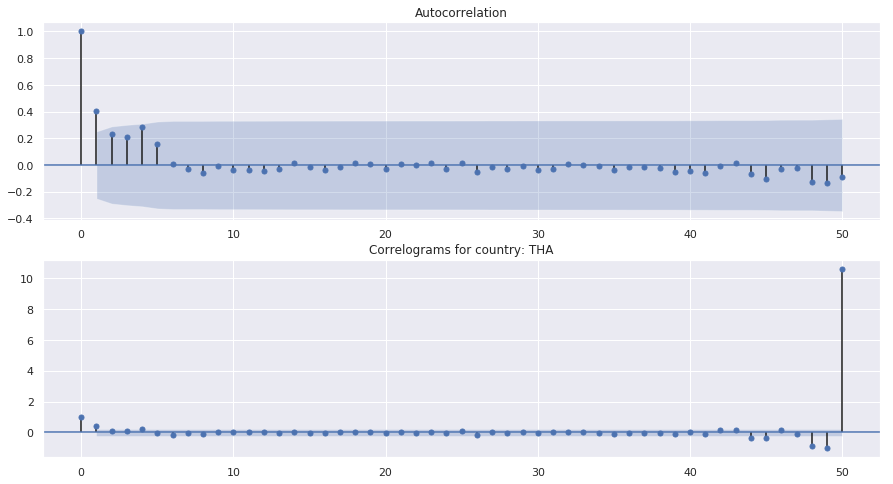

ARIMAX model MSE for 10-step ahead forecast:24.859748200506186


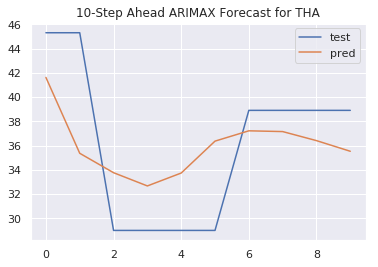

In [100]:
# Hotels, transportation*, flights*, restaurants, and tourism
tr_start,tr_end = '2018-01-07','2020-05-31'
te_start,te_end = '2020-06-07','2020-06-28'
exog_vars=['hotels','restaurants','tourism']

fit_arimax('THA', exog_vars, tr_start, tr_end, te_start, te_end, order = (5,1,5), n=-30)

### Indonesia

                           Statespace Model Results                           
Dep. Variable:                    pmi   No. Observations:                  107
Model:               SARIMAX(4, 1, 5)   Log Likelihood                -233.560
Date:                Mon, 27 Jul 2020   AIC                            491.120
Time:                        14:09:33   BIC                            522.382
Sample:                             0   HQIC                           503.772
                                - 107                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
restaurants    -0.0677      0.136     -0.499      0.618      -0.333       0.198
tourism         0.0815      0.166      0.490      0.624      -0.244       0.407
ar.L1           0.1044     61.792      0.002    

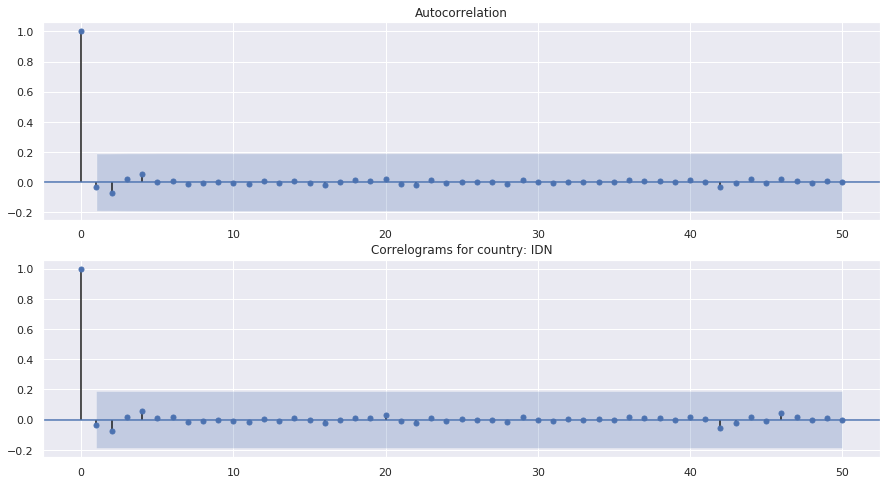

ARIMAX model MSE for 10-step ahead forecast:387.6630358314275


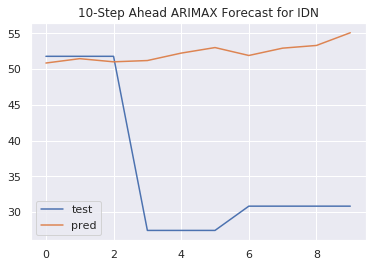

In [106]:
# Hotels, transportation*, flights*, restaurants, and tourism
tr_start,tr_end = '2018-01-07','2020-05-31'
te_start,te_end = '2020-06-07','2020-06-28'
exog_vars=['restaurants','tourism']

fit_arimax('IDN', exog_vars, tr_start, tr_end, te_start, te_end, order = (4,1,5), n=-30)

### Philippines

                           Statespace Model Results                           
Dep. Variable:                    pmi   No. Observations:                   72
Model:               SARIMAX(5, 0, 5)   Log Likelihood                -144.193
Date:                Mon, 27 Jul 2020   AIC                            316.386
Time:                        14:06:10   BIC                            347.042
Sample:                             0   HQIC                           328.500
                                 - 72                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
hotels          0.0994      0.053      1.886      0.059      -0.004       0.203
restaurants     0.0724      0.074      0.981      0.326      -0.072       0.217
tourism         0.0481      0.052      0.921    

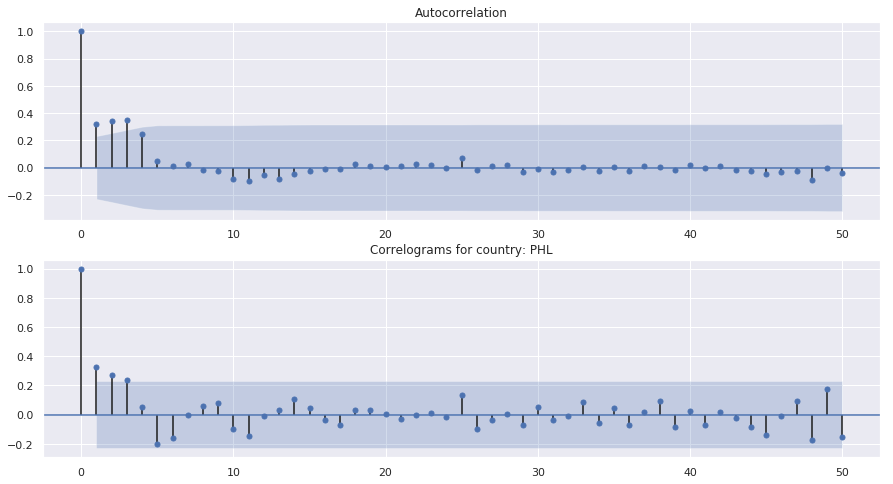

ARIMAX model MSE for 10-step ahead forecast:71.21494759584687


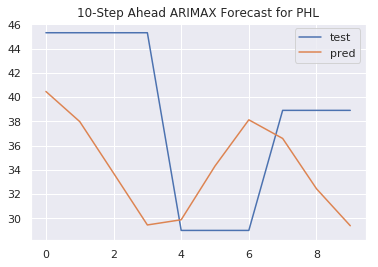

In [102]:
# Hotels, transportation*, flights*, restaurants, and tourism
tr_start,tr_end = '2018-01-07','2020-05-31'
te_start,te_end = '2020-06-07','2020-06-28'
exog_vars=['hotels','restaurants','tourism']

fit_arimax('PHL', exog_vars, tr_start, tr_end, te_start, te_end, order = (5,0,5), n=-19)

### Singapore

                           Statespace Model Results                           
Dep. Variable:                    pmi   No. Observations:                   71
Model:               SARIMAX(1, 1, 4)   Log Likelihood                 -42.540
Date:                Mon, 27 Jul 2020   AIC                            103.081
Time:                        14:06:40   BIC                            122.650
Sample:                             0   HQIC                           110.802
                                 - 71                                         
Covariance Type:                  opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
hotels         -0.0015      0.008     -0.175      0.861      -0.018       0.015
restaurants    -0.0101      0.009     -1.069      0.285      -0.029       0.008
tourism        -0.0096      0.011     -0.861    

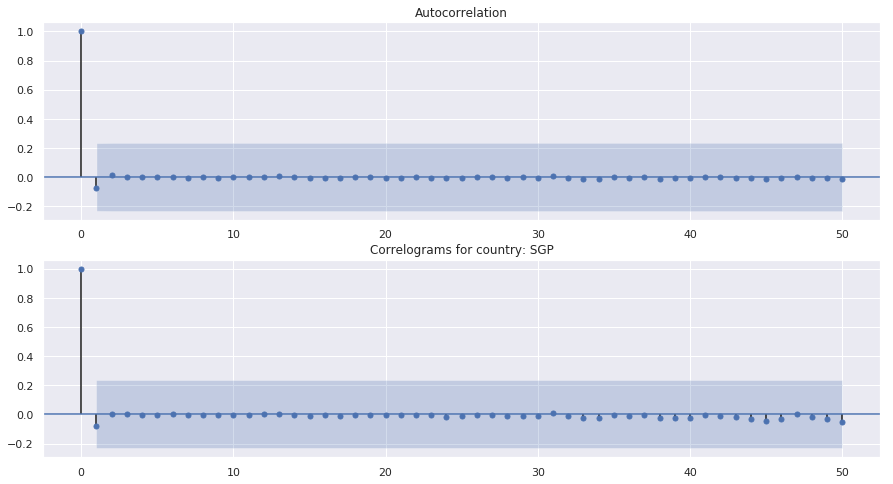

ARIMAX model MSE for 10-step ahead forecast:2.486352853087224


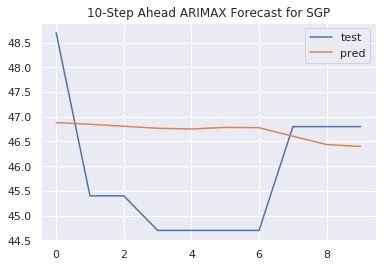

In [103]:
# Hotels, transportation*, flights*, restaurants, and tourism
tr_start,tr_end = '2018-01-07','2020-05-31'
te_start,te_end = '2020-06-07','2020-06-28'
exog_vars=['hotels','restaurants','tourism']

fit_arimax('SGP', exog_vars, tr_start, tr_end, te_start, te_end, order = (1,1,4), n=-20)